# Phase 0: Finding Datasets

I used daily ecosystem flux data sets, from the FLUXNET2015 database, of six different FLUXNET sites that span diverse ecosystems including forests, grasslands, and savannas. First step is to join them into one cohesive dataset for unified preprocessing and modeling.

In [5]:
import pandas as pd
import numpy as np
import glob

### ------------------ Concate the complete dataframe -----------------------###

# Define files and corresponding site names
site_files = {
    "US-Var": "/content/drive/MyDrive/Ds_Course/ML_course/Final_project/Data/AMF_US-Var_FLUXNET_SUBSET_DD_2000-2021_3-5.csv",
    "US-UMB": "/content/drive/MyDrive/Ds_Course/ML_course/Final_project/Data/AMF_US-UMB_FLUXNET_SUBSET_DD_2007-2021_3-5.csv",
    "US-Ton": "/content/drive/MyDrive/Ds_Course/ML_course/Final_project/Data/AMF_US-Ton_FLUXNET_SUBSET_DD_2001-2023_4-6.csv",
    "US-MMS": "/content/drive/MyDrive/Ds_Course/ML_course/Final_project/Data/AMF_US-MMS_FLUXNET_SUBSET_DD_1999-2020_3-5.csv",
    "US-Kon": "/content/drive/MyDrive/Ds_Course/ML_course/Final_project/Data/AMF_US-Kon_FLUXNET_SUBSET_DD_2004-2019_4-6.csv",
    "US-Ha1": "/content/drive/MyDrive/Ds_Course/ML_course/Final_project/Data/AMF_US-Ha1_FLUXNET_SUBSET_DD_1991-2020_3-5.csv"
}


# Define target and predictors
target = "GPP_NT_VUT_REF"
predictors = [
    "TA_F",        # Air temperature
    "VPD_F",       # Vapor pressure deficit
    "SW_IN_F",     # Shortwave radiation
    "PA_F",        # Air pressure
    "P_F",         # Precipitation
    "WS_F",        # Wind speed
    "LE_F_MDS",    # Latent heat flux
    "H_F_MDS",     # Sensible heat flux
    "G_F_MDS",     # Ground heat flux
    "PPFD_IN",     # Photosynthetic photon flux density
    "NETRAD"       # Net radiation
]

# Select columns
columns = ["TIMESTAMP", target] + predictors

# Load, label, and clean all data
dataframes = []
for site, filename in site_files.items():
    df = pd.read_csv(filename)
    df.replace(-9999, np.nan, inplace=True)
    df = df[columns].copy()
    df["site"] = site
    df.dropna(subset=[target] + predictors, inplace=True)
    dataframes.append(df)


# Concatenate all into one dataframe
df_all = pd.concat(dataframes, ignore_index=True)

print(f"Combined dataset shape: {df_all.shape}")
print("Sample rows:")
print(df_all.head())

# Save to CSV
df_all.to_csv("/content/drive/MyDrive/Ds_Course/ML_course/Final_project/Data/combined_GPP_daily_FLUXNET.csv", index=False)



Combined dataset shape: (20895, 14)
Sample rows:
   TIMESTAMP  GPP_NT_VUT_REF    TA_F   VPD_F  SW_IN_F    PA_F    P_F   WS_F  \
0   20001023         2.62240  15.701  13.275  144.241  99.323   0.00  1.491   
1   20001024         2.91881  17.417  13.553  145.474  99.766   0.00  1.271   
2   20001025         2.34361  12.739   3.778  151.173  99.274   9.40  1.507   
3   20001026         2.53444  11.951   1.259  145.879  98.674  12.71  1.061   
4   20001027         2.73883  13.275   0.054  143.659  98.925   0.25  1.038   

   LE_F_MDS  H_F_MDS   G_F_MDS     PPFD_IN     NETRAD    site  
0   36.6987  15.8514  -2.01391  320.536437  31.407500  US-Var  
1   35.0201  15.1848   2.86117  323.274771  32.938333  US-Var  
2   27.9223  19.6019 -16.16670  335.939979 -17.709167  US-Var  
3   24.5069  17.9867 -15.56250  324.175317  -6.443104  US-Var  
4   26.5328  19.5727  -9.04170  319.243033  43.107917  US-Var  


# Phase 1: Data Exploration and Cleaning

### 1. Dataset Structure and Overview

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# === Load the Combined Data Set ===
df_all = pd.read_csv("/content/drive/MyDrive/Ds_Course/ML_course/Final_project/Data/combined_GPP_daily_FLUXNET.csv")

# datset shape check
print(f"Combined dataset shape: {df_all.shape}")
print("Sample rows:")
print(df_all.head())

# Get basic descriptive statistics
descriptives = df_all.describe()

# Get count of rows per site
site_counts = df_all["site"].value_counts().rename_axis("site").reset_index(name="row_count")

# Display the stats
print("\n📈 Descriptive statistics:")
print(descriptives)

print("\n📍 Number of records per site:")
print(site_counts)

# === Data Types, Missing Values, and Overview ===
print("\nData types:\n", df_all.dtypes)
print("\nMissing values per column:\n", df_all.isnull().sum())
print("\nUnique sites:", df_all['site'].nunique())
print("\nSite counts:\n", df_all['site'].value_counts())


Combined dataset shape: (20895, 14)
Sample rows:
   TIMESTAMP  GPP_NT_VUT_REF    TA_F   VPD_F  SW_IN_F    PA_F    P_F   WS_F  \
0   20001023         2.62240  15.701  13.275  144.241  99.323   0.00  1.491   
1   20001024         2.91881  17.417  13.553  145.474  99.766   0.00  1.271   
2   20001025         2.34361  12.739   3.778  151.173  99.274   9.40  1.507   
3   20001026         2.53444  11.951   1.259  145.879  98.674  12.71  1.061   
4   20001027         2.73883  13.275   0.054  143.659  98.925   0.25  1.038   

   LE_F_MDS  H_F_MDS   G_F_MDS     PPFD_IN     NETRAD    site  
0   36.6987  15.8514  -2.01391  320.536437  31.407500  US-Var  
1   35.0201  15.1848   2.86117  323.274771  32.938333  US-Var  
2   27.9223  19.6019 -16.16670  335.939979 -17.709167  US-Var  
3   24.5069  17.9867 -15.56250  324.175317  -6.443104  US-Var  
4   26.5328  19.5727  -9.04170  319.243033  43.107917  US-Var  

📈 Descriptive statistics:
          TIMESTAMP  GPP_NT_VUT_REF          TA_F         VPD_F  

## 2. Correlation Analysis

correlations Of All features (Predictors + Target)

                TA_F  VPD_F  SW_IN_F  PA_F   P_F  WS_F  LE_F_MDS  H_F_MDS  \
TA_F            1.00   0.77     0.68 -0.03 -0.08 -0.24      0.33     0.46   
VPD_F           0.77   1.00     0.69  0.05 -0.24 -0.27      0.02     0.64   
SW_IN_F         0.68   0.69     1.00  0.02 -0.34 -0.28      0.41     0.77   
PA_F           -0.03   0.05     0.02  1.00 -0.12 -0.61     -0.26     0.18   
P_F            -0.08  -0.24    -0.34 -0.12  1.00  0.19     -0.05    -0.32   
WS_F           -0.24  -0.27    -0.28 -0.61  0.19  1.00      0.13    -0.35   
LE_F_MDS        0.33   0.02     0.41 -0.26 -0.05  0.13      1.00    -0.13   
H_F_MDS         0.46   0.64     0.77  0.18 -0.32 -0.35     -0.13     1.00   
G_F_MDS         0.76   0.65     0.68 -0.10 -0.10 -0.10      0.26     0.51   
PPFD_IN         0.68   0.69     0.99  0.06 -0.33 -0.29      0.39     0.79   
NETRAD          0.58   0.52     0.87  0.02 -0.23 -0.25      0.45     0.62   
GPP_NT_VUT_REF  0.32  -0

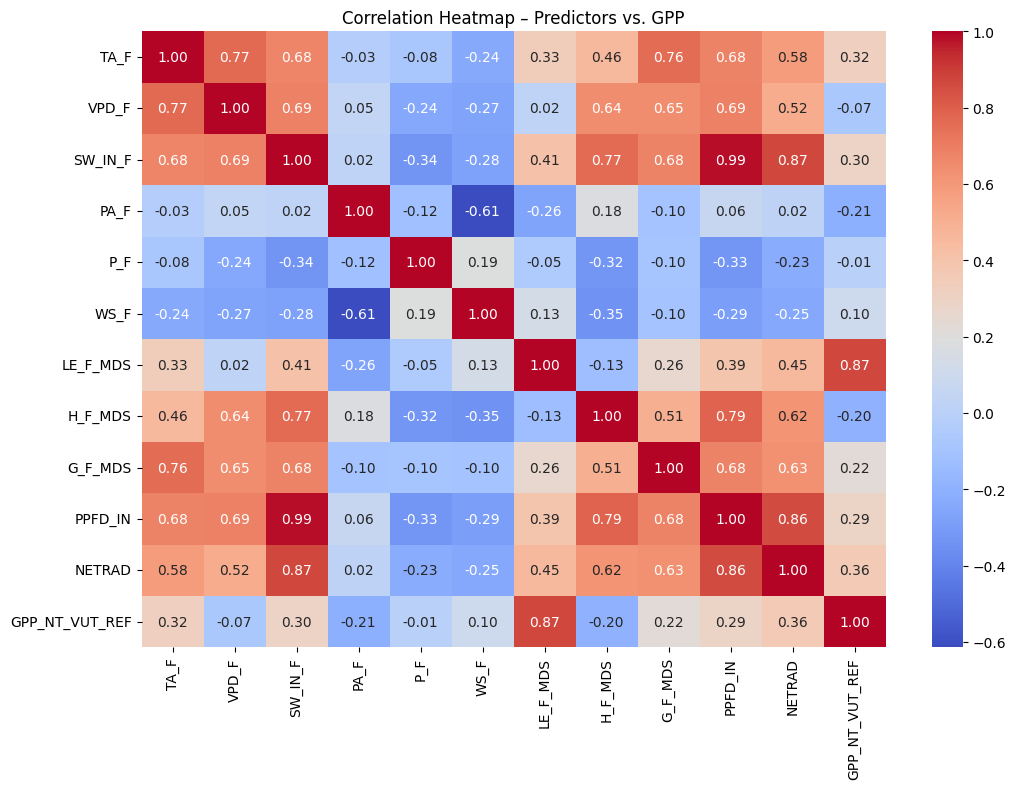


Correlations of refined features (Choosen Predictors + Target)

                TA_F  VPD_F  PA_F   P_F  WS_F  LE_F_MDS  H_F_MDS  G_F_MDS  \
TA_F            1.00   0.77 -0.03 -0.08 -0.24      0.33     0.46     0.76   
VPD_F           0.77   1.00  0.05 -0.24 -0.27      0.02     0.64     0.65   
PA_F           -0.03   0.05  1.00 -0.12 -0.61     -0.26     0.18    -0.10   
P_F            -0.08  -0.24 -0.12  1.00  0.19     -0.05    -0.32    -0.10   
WS_F           -0.24  -0.27 -0.61  0.19  1.00      0.13    -0.35    -0.10   
LE_F_MDS        0.33   0.02 -0.26 -0.05  0.13      1.00    -0.13     0.26   
H_F_MDS         0.46   0.64  0.18 -0.32 -0.35     -0.13     1.00     0.51   
G_F_MDS         0.76   0.65 -0.10 -0.10 -0.10      0.26     0.51     1.00   
PPFD_IN         0.68   0.69  0.06 -0.33 -0.29      0.39     0.79     0.68   
NETRAD          0.58   0.52  0.02 -0.23 -0.25      0.45     0.62     0.63   
GPP_NT_VUT_REF  0.32  -0.07 -0.21 -0.01  0.10      0.87    -0.20     0.22   

          

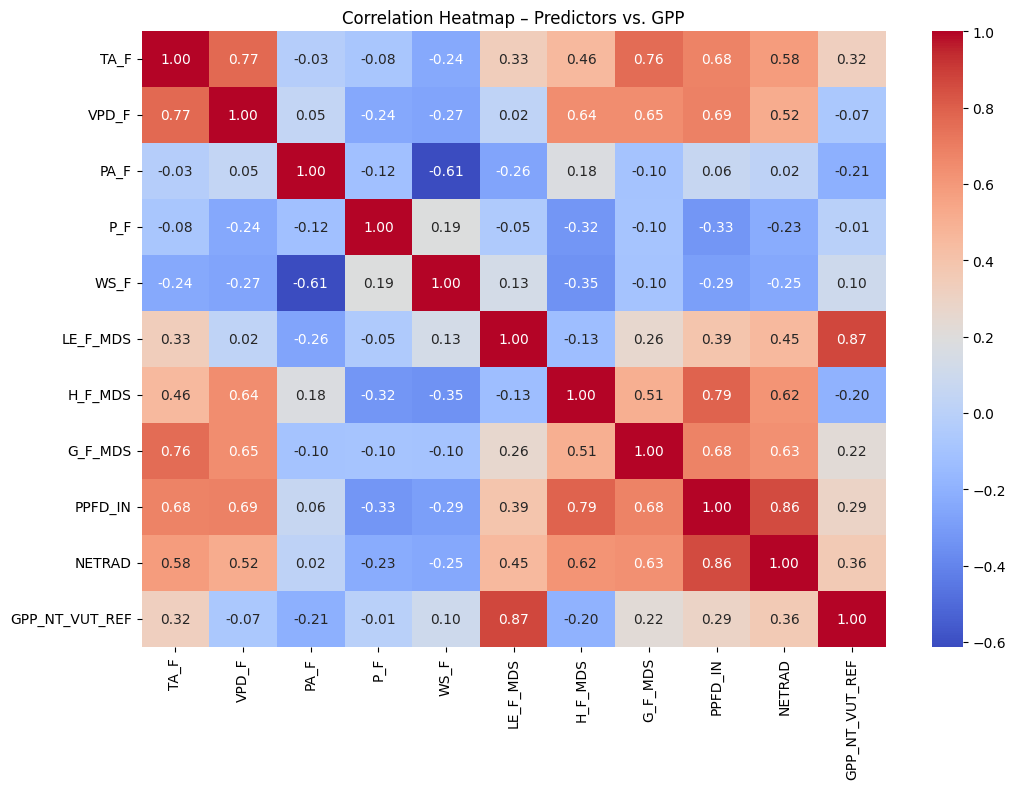

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Correlation Matrix ===
correlation = df_all[predictors + [target]].corr()
print("correlations Of All features (Predictors + Target)\n")
print(correlation.round(2))

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap – Predictors vs. GPP")
plt.show()

# Safely drop SW_IN_F if it's still in the data
if "SW_IN_F" in df.columns:
  df.drop(columns=["SW_IN_F"], inplace=True)

# Safely remove from predictors
if "SW_IN_F" in predictors:
    predictors.remove("SW_IN_F")

# === Recalculate and show Correlation Matrix ===
correlation = df_all[predictors + [target]].corr()
print("\nCorrelations of refined features (Choosen Predictors + Target)\n")
print(correlation.round(2))

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap – Predictors vs. GPP")
plt.show()


## 3. Visual Exploration and Pattern Detection

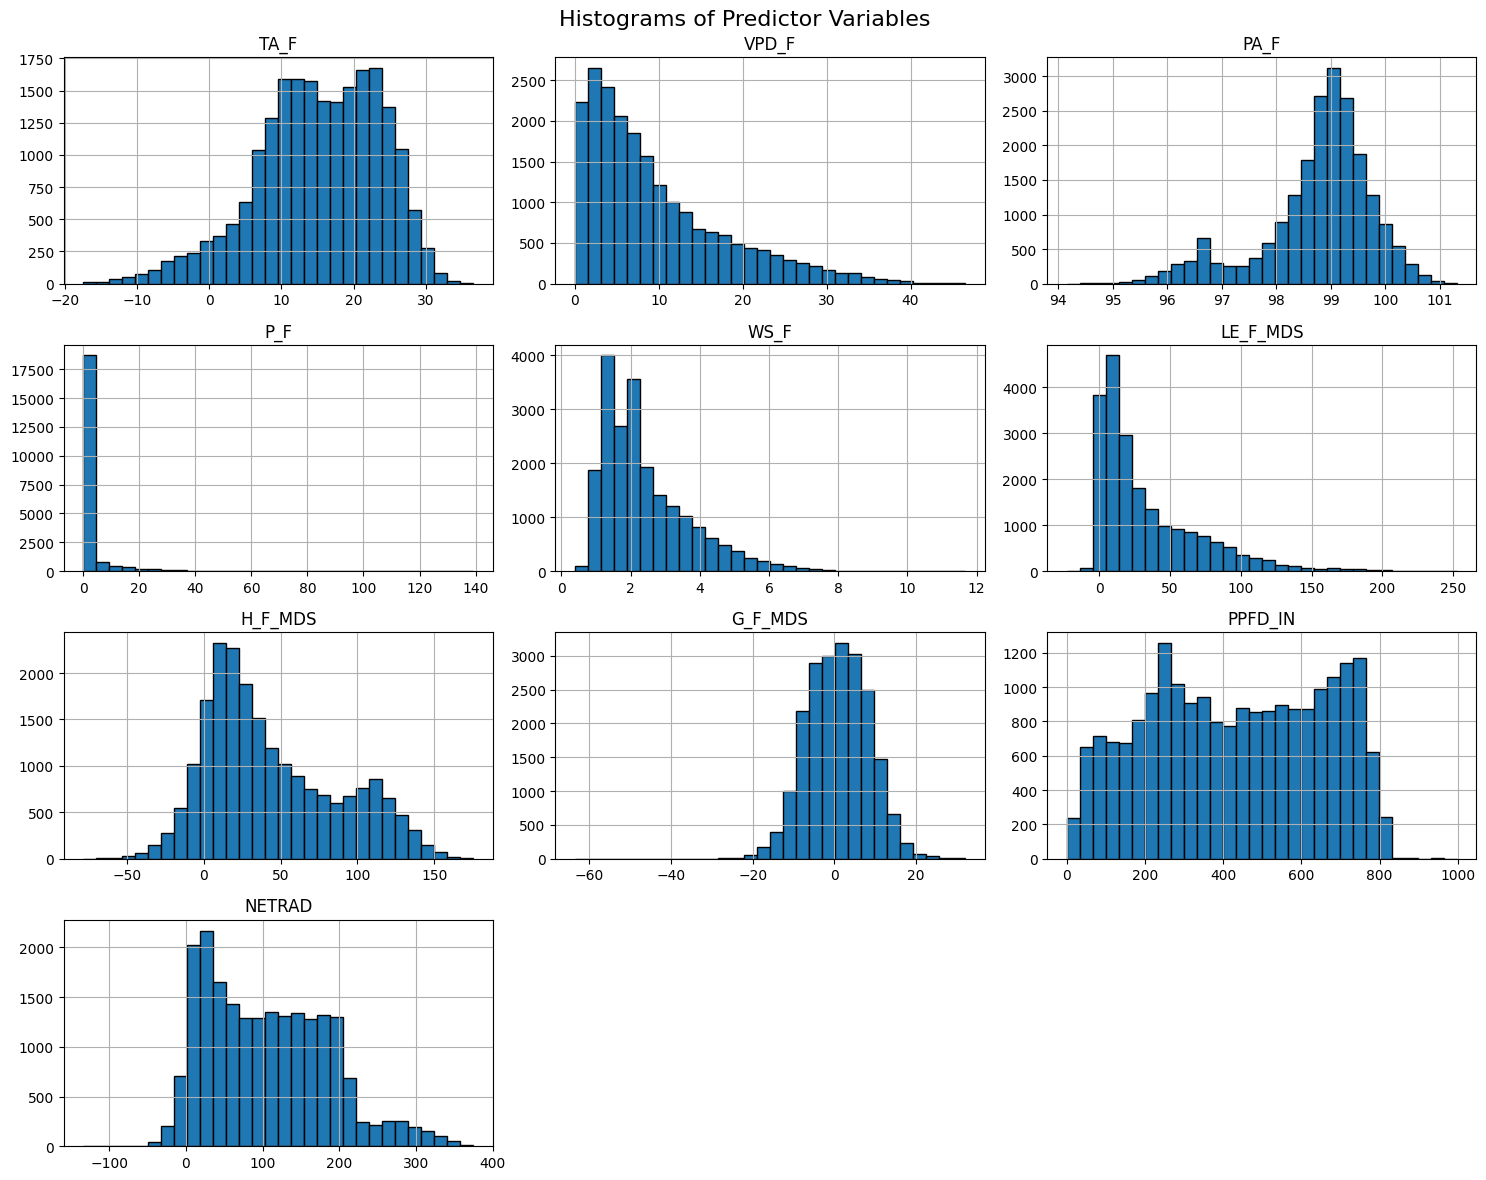

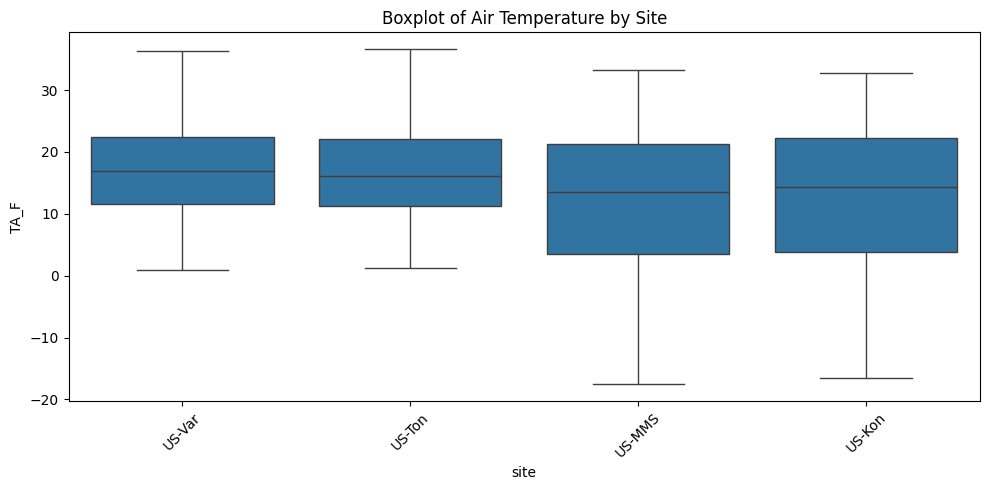

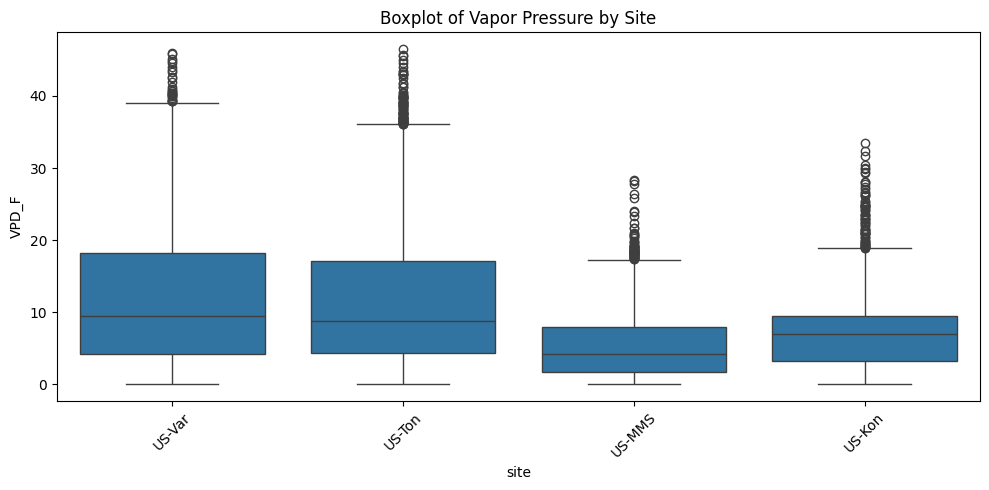

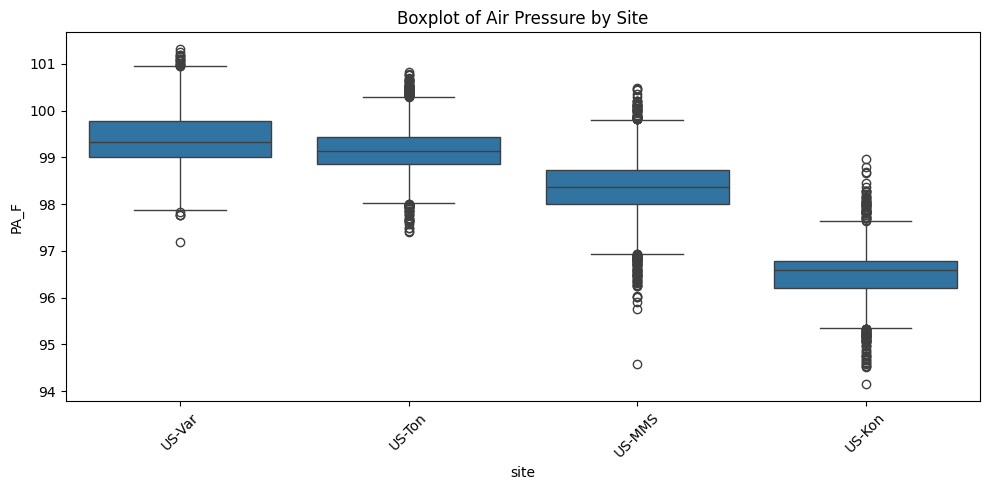

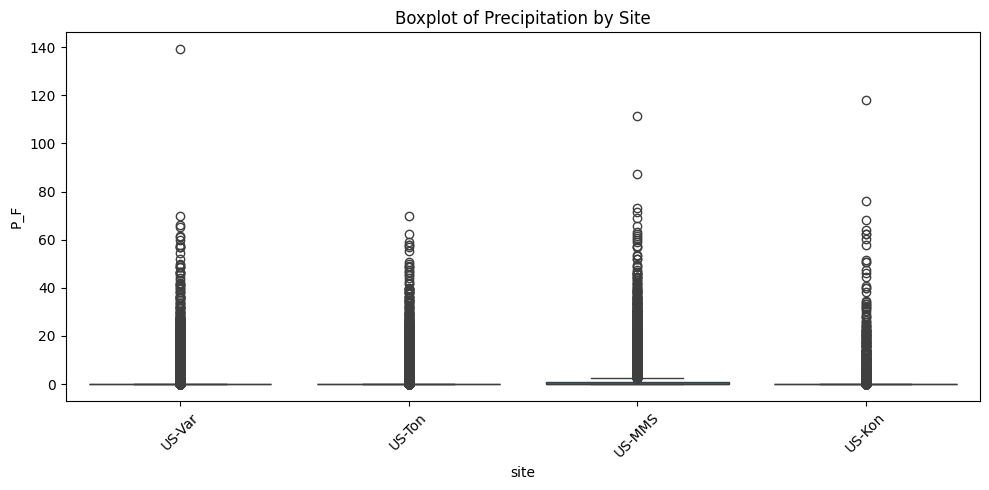

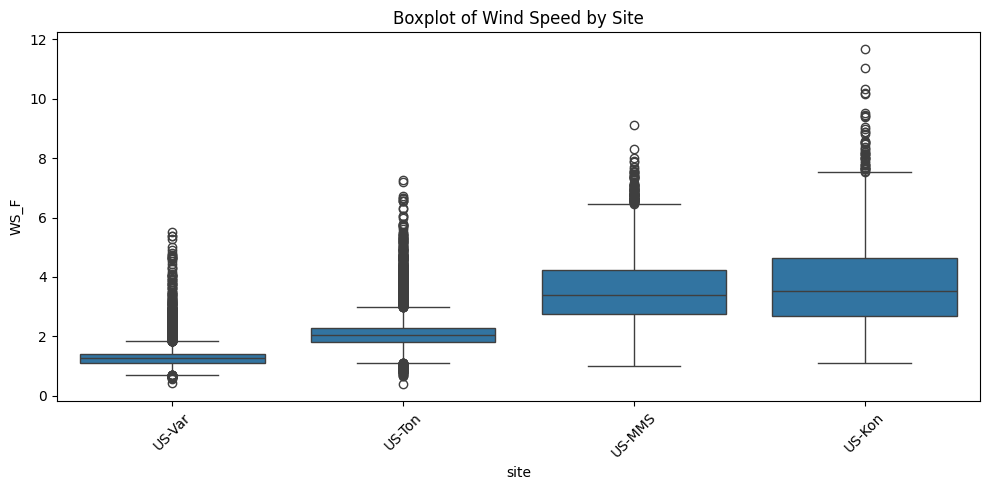

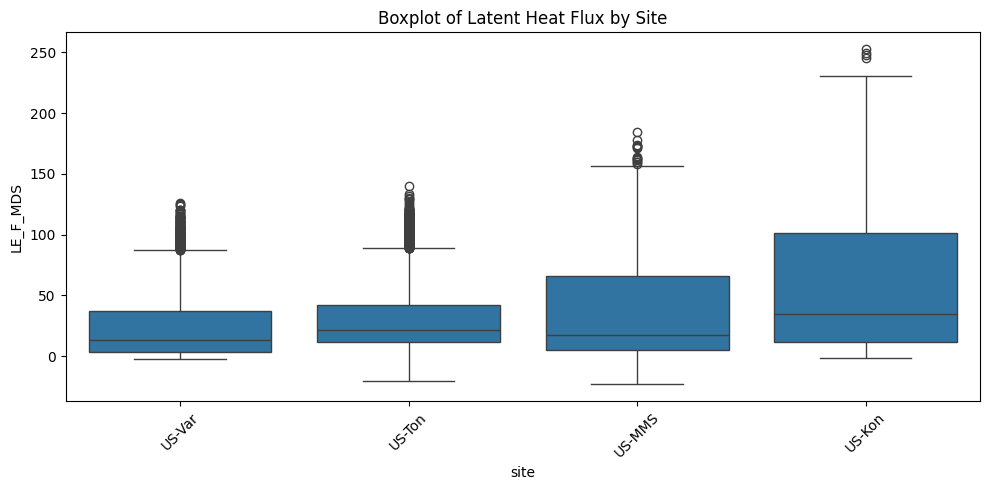

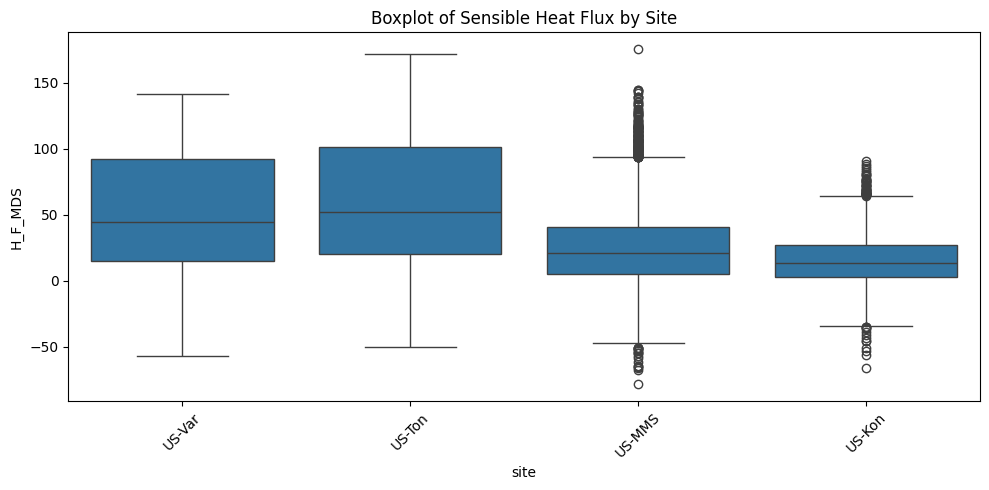

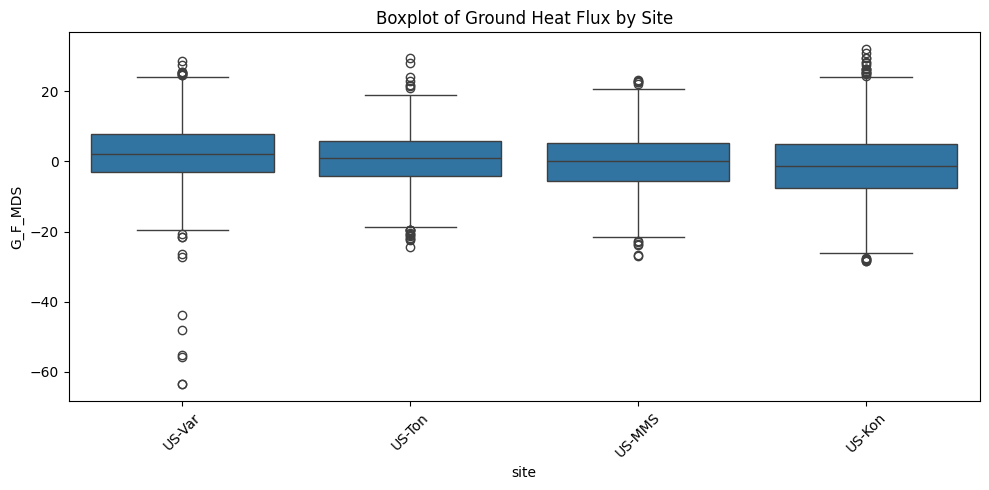

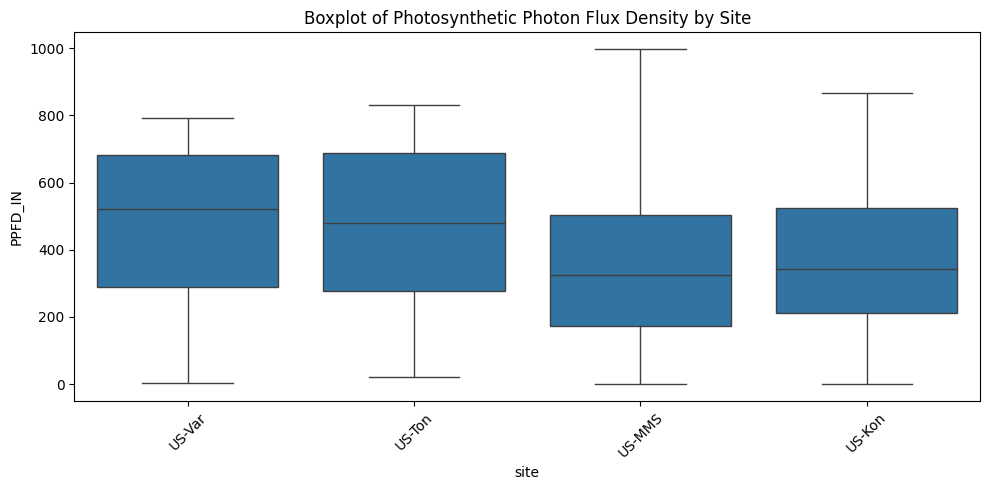

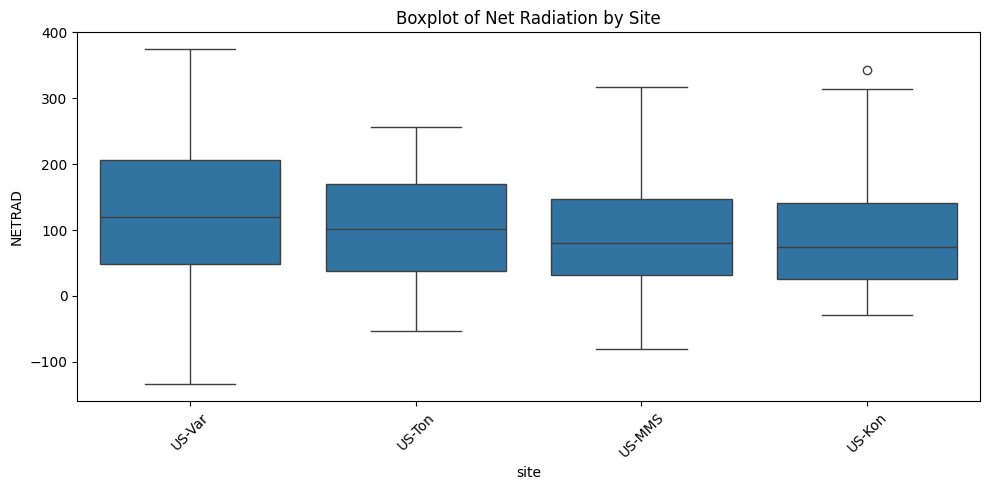

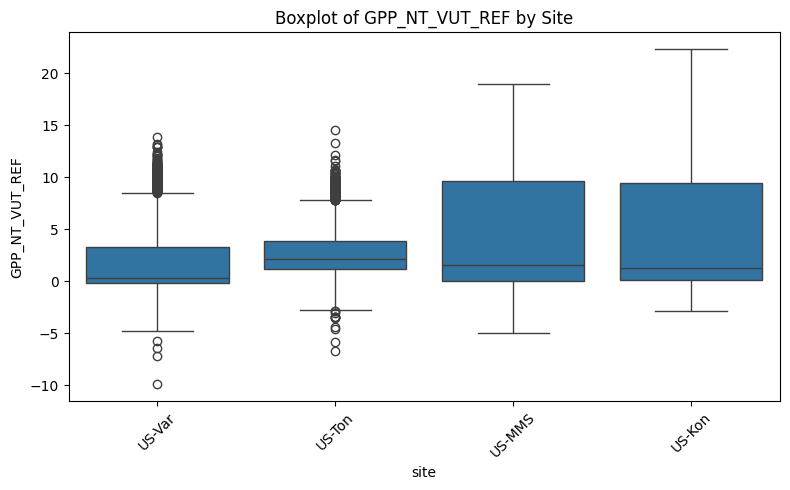

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# for readble plot title, define features code:name dictionary
feature_names = {
    "GPP_NT_VUT_REF": "Gross Primary Productivity",
    "TA_F": "Air Temperature",
    "VPD_F": "Vapor Pressure",
    "PPFD_IN": "Photosynthetic Photon Flux Density",
    "PA_F": "Air Pressure",
    "P_F": "Precipitation",
    "WS_F": "Wind Speed",
    "LE_F_MDS": "Latent Heat Flux",
    "H_F_MDS": "Sensible Heat Flux",
    "G_F_MDS": "Ground Heat Flux",
    "NETRAD": "Net Radiation"
}

# === 1. Histograms of all predictors ===
df_all[predictors].hist(bins=30, figsize=(15, 12), edgecolor='black')
plt.suptitle("Histograms of Predictor Variables", fontsize=16)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Ds_Course/ML_course/Final_project/Exports/histograms_predictors.png")  # Save for report
plt.show()

# === 2. Boxplots of predictors by site ===
for feature in predictors:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x="site", y=feature, data=df_all)
    title = feature_names.get(feature, feature)  # fallback to feature name if not found
    plt.title(f"Boxplot of {title} by Site")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/Ds_Course/ML_course/Final_project/Exports/boxplot_{feature}.png")
    plt.show()

# === 3. Boxplot for GPP by site ===
plt.figure(figsize=(8, 5))
sns.boxplot(x="site", y=target, data=df_all)
plt.title("Boxplot of GPP_NT_VUT_REF by Site")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("boxplot_gpp_by_site.png")
plt.show()


## 4. Feature Engineering


Missing values per column:
 TIMESTAMP            0
GPP_NT_VUT_REF       0
TA_F                 0
VPD_F                0
SW_IN_F              0
PA_F                 0
P_F                  0
WS_F                 0
LE_F_MDS             0
H_F_MDS              0
G_F_MDS              0
PPFD_IN              0
NETRAD               0
site                 0
TEMP_X_VPD           0
RADIATION_BALANCE    0
GPP_LAG1             0
GPP_DIFF             0
GPP_VAR7             0
dtype: int64

Correlation with GPP (incl. engineered features):

GPP_NT_VUT_REF       1.00
GPP_LAG1             0.95
LE_F_MDS             0.87
GPP_VAR7             0.48
NETRAD               0.36
RADIATION_BALANCE    0.36
TA_F                 0.32
PPFD_IN              0.29
G_F_MDS              0.22
GPP_DIFF             0.16
WS_F                 0.10
P_F                 -0.01
TEMP_X_VPD          -0.04
VPD_F               -0.07
H_F_MDS             -0.20
PA_F                -0.21
Name: GPP_NT_VUT_REF, dtype: float64


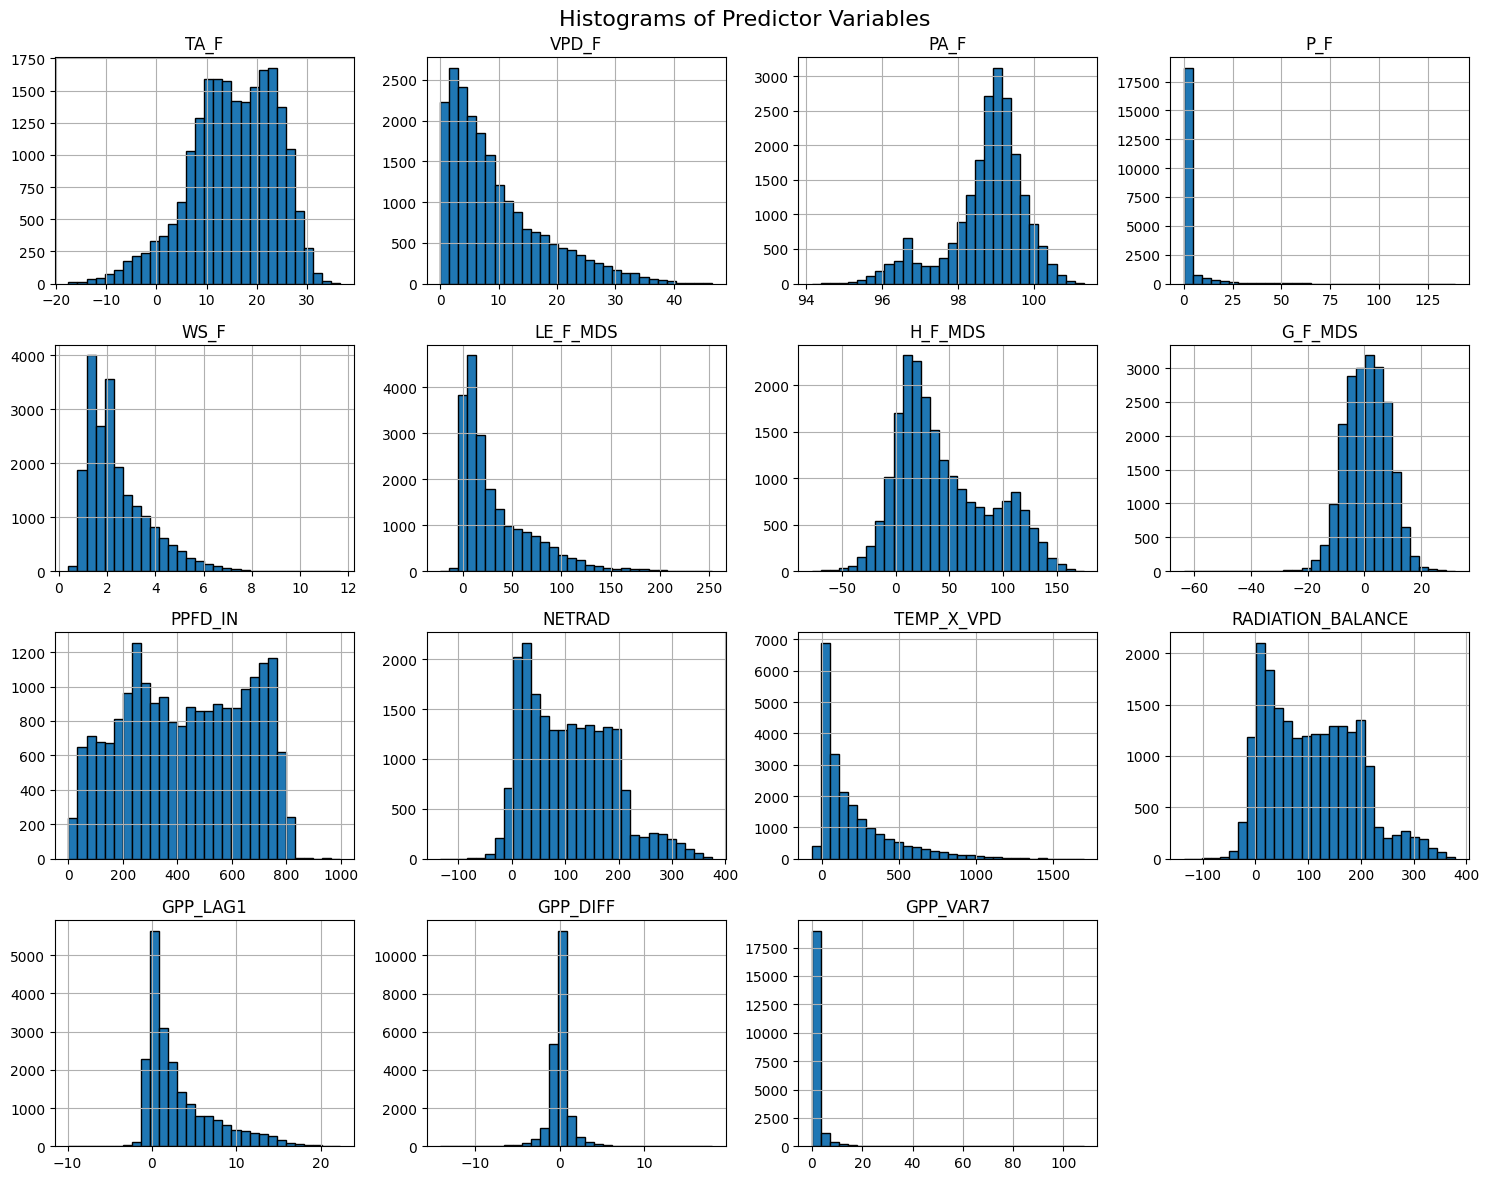


Correlation of Standardized Predictor with GPP (incl. engineered features):

GPP_NT_VUT_REF       1.00
GPP_LAG1             0.95
LE_F_MDS             0.87
GPP_VAR7             0.48
NETRAD               0.36
RADIATION_BALANCE    0.36
TA_F                 0.32
PPFD_IN              0.29
G_F_MDS              0.22
GPP_DIFF             0.16
WS_F                 0.10
P_F                 -0.01
TEMP_X_VPD          -0.04
VPD_F               -0.07
H_F_MDS             -0.20
PA_F                -0.21
Name: GPP_NT_VUT_REF, dtype: float64


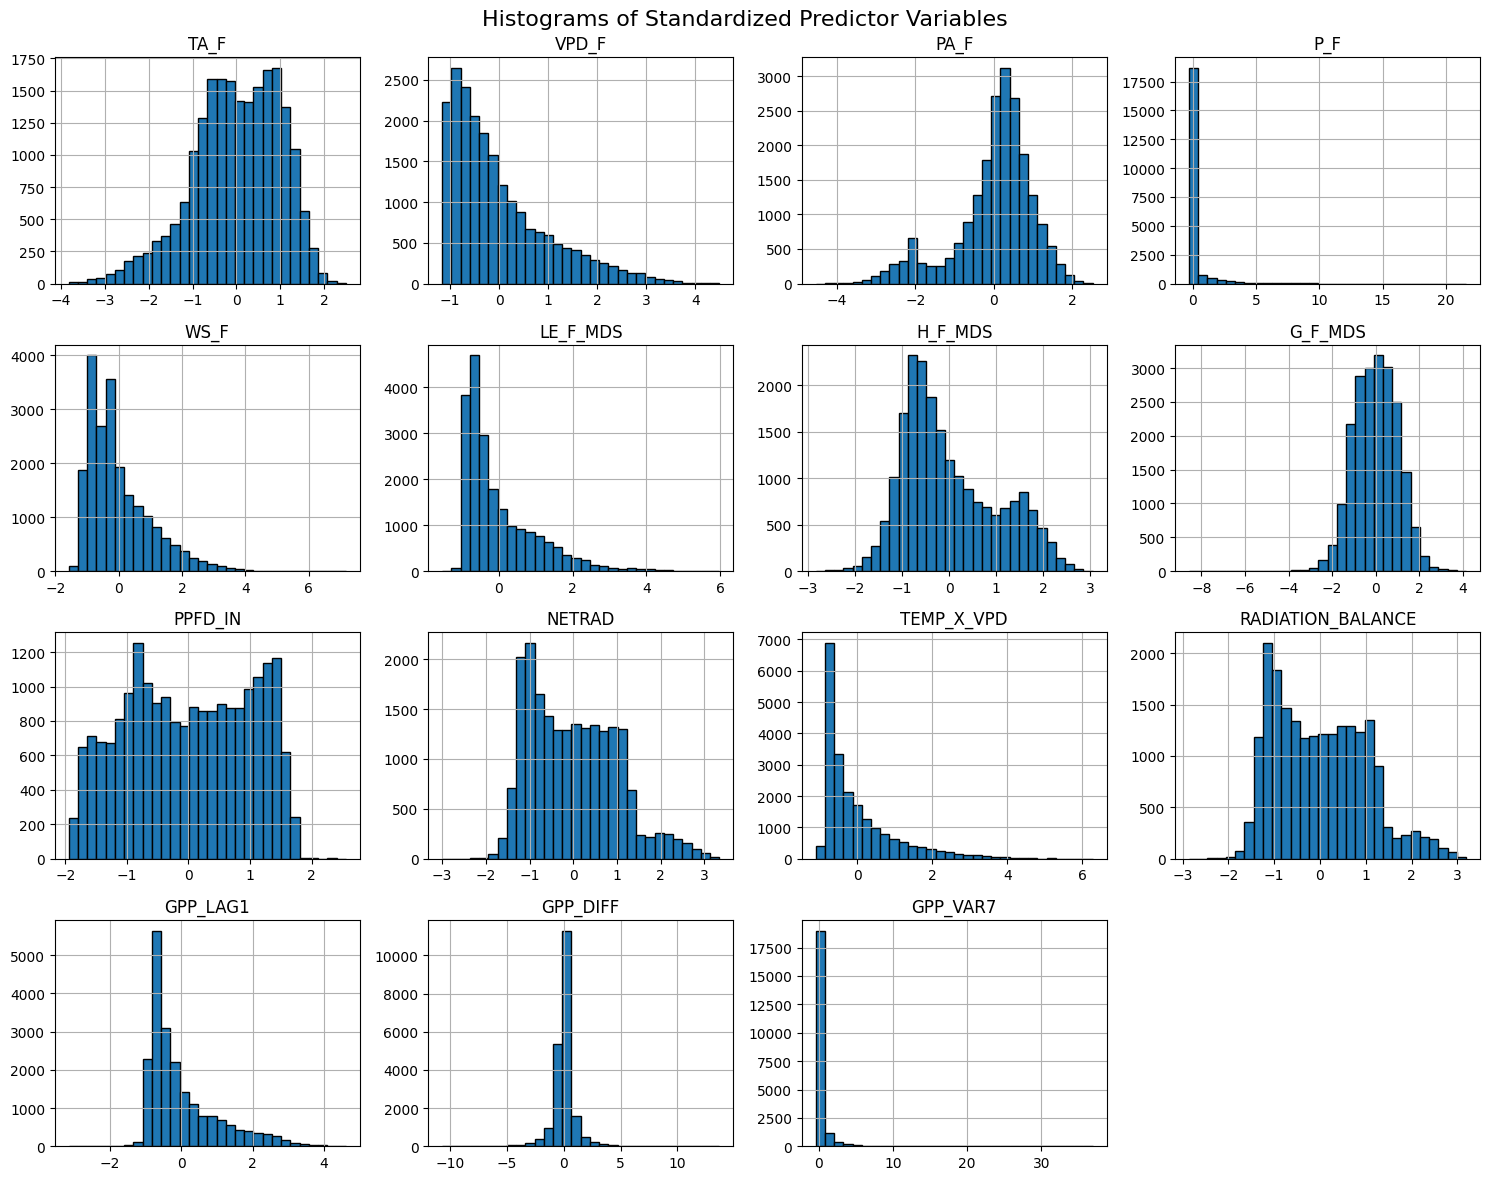

In [9]:
from sklearn.preprocessing import StandardScaler

# === Create New Features (only if not already present) ===
if "TEMP_X_VPD" not in df_all.columns:
    df_all["TEMP_X_VPD"] = df_all["TA_F"] * df_all["VPD_F"]

if "RADIATION_BALANCE" not in df_all.columns:
    df_all["RADIATION_BALANCE"] = df_all["NETRAD"] + df_all["G_F_MDS"]

# Add to predictors list (only if not already added)
for col in ["TEMP_X_VPD", "RADIATION_BALANCE"]:
    if col not in predictors:
        predictors.append(col)

# === Create Temporal Features Per Site ===
df_all = df_all.sort_values(["site", "TIMESTAMP"])

# Create temporal features only if they don't exist
if "GPP_LAG1" not in df_all.columns:
    df_all["GPP_LAG1"] = df_all.groupby("site")[target].shift(1)

if "GPP_DIFF" not in df_all.columns:
    df_all["GPP_DIFF"] = df_all[target] - df_all["GPP_LAG1"]

if "GPP_VAR7" not in df_all.columns:
    df_all["GPP_VAR7"] = df_all.groupby("site")[target].rolling(window=7).var().reset_index(0, drop=True)

# Drop rows with missing values caused by shifting/rolling
df_all.dropna(subset=["GPP_LAG1", "GPP_DIFF", "GPP_VAR7"], inplace=True)

# make sure no missing values in dataset
print("\nMissing values per column:\n", df_all.isnull().sum())

# Add to predictors list (only if not already added)
for col in ["GPP_LAG1", "GPP_DIFF", "GPP_VAR7"]:
    if col not in predictors:
        predictors.append(col)


# Check new correlation of engineered features
correlation = df_all[predictors + [target]].corr()
print("\nCorrelation with GPP (incl. engineered features):\n")
print(correlation[target].sort_values(ascending=False).round(2))

# === Histograms of all features (include engineered features)===
df_all[predictors].hist(bins=30, figsize=(15, 12), edgecolor='black')
plt.suptitle("Histograms of Predictor Variables", fontsize=16)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Ds_Course/ML_course/Final_project/Exports/histograms_predictors.png")  # Save for report
plt.show()

# === Scale All Features  ===
scaler = StandardScaler()
df_scaled = df_all.copy()
df_scaled[predictors] = scaler.fit_transform(df_all[predictors])

# Check correlation of standardized engineered features
correlation = df_scaled[predictors + [target]].corr()
print("\nCorrelation of Standardized Predictor with GPP (incl. engineered features):\n")
print(correlation[target].sort_values(ascending=False).round(2))

# === Histograms of all standardized predictors ===
df_scaled[predictors].hist(bins=30, figsize=(15, 12), edgecolor='black')
plt.suptitle("Histograms of Standardized Predictor Variables", fontsize=16)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Ds_Course/ML_course/Final_project/Exports/histograms_standadized_predictors.png")  # Save for report
plt.show()


# Phase 2: Hypothesis Formulation

## Hypothesis Formulation
Gross Primary Productivity (GPP) can be accurately predicted from daily measurements of ecosystem energy fluxes, atmospheric conditions, and recent gpp temporal trends across diverse terrestrial biomes.

## Most Important Trends, Relationships, and Features Identification

### interaction effects between features and the target

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit an interaction model using a few top features (example: TA_F * VPD_F and TA_F * LE_F_MDS)
interaction_model = smf.ols(
    formula="GPP_NT_VUT_REF ~ TA_F * VPD_F + TA_F * LE_F_MDS + LE_F_MDS * VPD_F",
    data=df_all
).fit()

# Summary of interaction terms
print(interaction_model.summary())


                            OLS Regression Results                            
Dep. Variable:         GPP_NT_VUT_REF   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                 1.538e+04
Date:                Mon, 05 May 2025   Prob (F-statistic):               0.00
Time:                        23:37:14   Log-Likelihood:                -41651.
No. Observations:               20871   AIC:                         8.332e+04
Df Residuals:                   20864   BIC:                         8.337e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0687      0.035     -1.

### Feature Importance

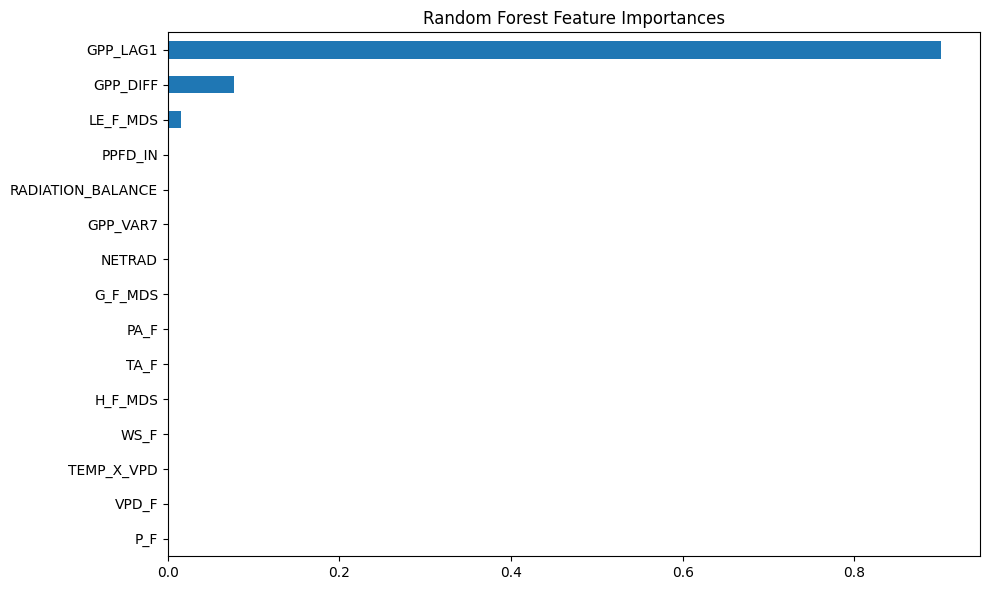

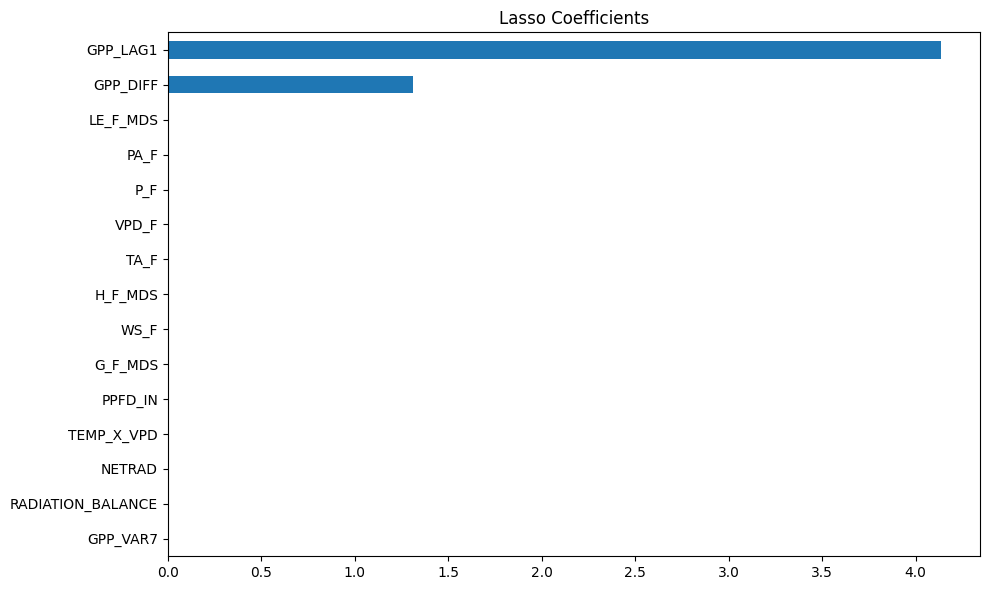

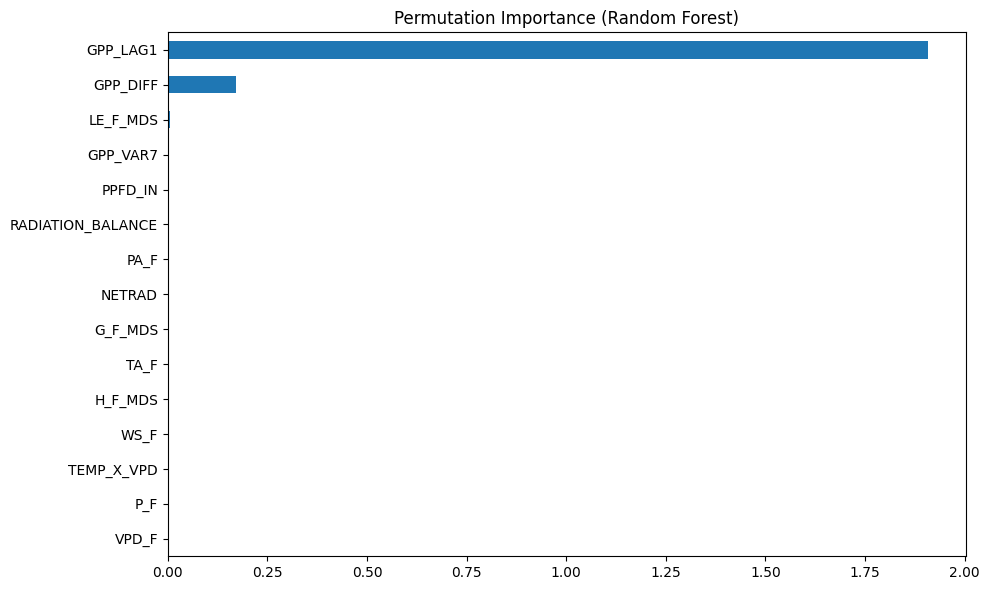


Top 10 Features by Random Forest Importance:
GPP_LAG1             0.901338
GPP_DIFF             0.077184
LE_F_MDS             0.015263
PPFD_IN              0.001854
RADIATION_BALANCE    0.001261
GPP_VAR7             0.000933
NETRAD               0.000915
G_F_MDS              0.000256
PA_F                 0.000230
TA_F                 0.000179
dtype: float64

Top 10 Features by Lasso Coefficients:
GPP_LAG1    4.138041
GPP_DIFF    1.310858
LE_F_MDS    0.003580
PA_F       -0.000000
P_F        -0.000000
VPD_F      -0.000000
TA_F        0.000000
H_F_MDS    -0.000000
WS_F        0.000000
G_F_MDS     0.000000
dtype: float64

Top 10 Features by Permutation Importance:
GPP_LAG1             1.907042
GPP_DIFF             0.169948
LE_F_MDS             0.004425
GPP_VAR7             0.000605
PPFD_IN              0.000426
RADIATION_BALANCE    0.000280
PA_F                 0.000109
NETRAD               0.000106
G_F_MDS              0.000089
TA_F                 0.000057
dtype: float64


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Define X and y
X = df_scaled[predictors]
y = df_scaled[target]  # standardized GPP

# === Feature Importance from Random Forest ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
rf_importance = pd.Series(rf.feature_importances_, index=predictors).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
rf_importance.plot(kind="barh")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("rf_importance.png")
plt.show()

# === Lasso Regularization ===
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X, y)
lasso_importance = pd.Series(lasso.coef_, index=predictors).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
lasso_importance.plot(kind="barh")
plt.title("Lasso Coefficients")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("lasso_importance.png")
plt.show()

# === Permutation Importance ===
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=42, scoring='r2')
perm_importance = pd.Series(perm.importances_mean, index=predictors).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
perm_importance.plot(kind="barh")
plt.title("Permutation Importance (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("perm_importance.png")
plt.show()

# Output top features from each method
print("\nTop 10 Features by Random Forest Importance:")
print(rf_importance.head(10))

print("\nTop 10 Features by Lasso Coefficients:")
print(lasso_importance.head(10))

print("\nTop 10 Features by Permutation Importance:")
print(perm_importance.head(10))


## Hypothesis Update
The highly predictive temporal variables such as GPP_LAG1, GPP_DIFF, and GPP_VAR7 rely on prior knowledge of the target variable. Such features can only be used for forecasting where previous GPP measurements are available. For estimating GPP in new or unmonitored ecosystems, models based on these variables are not applicable. therefore I will identify feature importance excluding any prior knowledge of the target variable

## updated Feature Importance

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import pandas as pd

# Define past-GPP-related features
gpp_history_features = ["GPP_LAG1", "GPP_DIFF", "GPP_VAR7"]

# Create datasets
predictors_with_gpp = predictors.copy()
predictors_no_gpp = [f for f in predictors if f not in gpp_history_features]

df_with_gpp_history = df_scaled.copy()
df_no_gpp_history = df_scaled.drop(columns=gpp_history_features)

# === Split data ===
X_with_gpp = df_with_gpp_history[predictors_with_gpp]
X_no_gpp = df_no_gpp_history[predictors_no_gpp]
y = df_with_gpp_history[target]

# === Feature Importance of data set without gpp history ===
X_train, X_test, y_train, y_test = train_test_split(X_no_gpp, y, test_size=0.2, random_state=42)

# === Random Forest Importance ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_importance = pd.Series(rf.feature_importances_, index=X_no_gpp.columns).sort_values(ascending=False)
print("Top 10 Features by Random Forest Importance (no GPP history):")
print(rf_importance.head(10))

# === Lasso Coefficients ===
lasso = Lasso(alpha=0.01, max_iter=10000)
lasso.fit(X_train, y_train)
lasso_importance = pd.Series(lasso.coef_, index=X_no_gpp.columns).sort_values(ascending=False)
print("\nTop 10 Features by Lasso Coefficients (no GPP history):")
print(lasso_importance.head(10))

# === Permutation Importance ===
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, scoring='r2')
perm_importance_mean = pd.Series(perm_importance.importances_mean, index=X_no_gpp.columns).sort_values(ascending=False)
print("\nTop 10 Features by Permutation Importance (no GPP history):")
print(perm_importance_mean.head(10))


Top 10 Features by Random Forest Importance (no GPP history):
LE_F_MDS             0.767070
TA_F                 0.046172
H_F_MDS              0.036829
VPD_F                0.027992
PA_F                 0.023516
WS_F                 0.022116
RADIATION_BALANCE    0.017600
PPFD_IN              0.015545
G_F_MDS              0.014691
NETRAD               0.013289
dtype: float64

Top 10 Features by Lasso Coefficients (no GPP history):
LE_F_MDS             2.838637
TEMP_X_VPD           1.465660
TA_F                 1.320849
PPFD_IN              0.752925
PA_F                 0.072255
WS_F                 0.001096
NETRAD              -0.000000
RADIATION_BALANCE   -0.000000
G_F_MDS             -0.101492
P_F                 -0.164635
dtype: float64

Top 10 Features by Permutation Importance (no GPP history):
LE_F_MDS             0.983054
TA_F                 0.159471
H_F_MDS              0.087740
VPD_F                0.081969
WS_F                 0.028872
PA_F                 0.022791
RADIATION_

## correlations and clusters

In [16]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. Pairplot for top predictors
top_predictors = ["LE_F_MDS", "TA_F","H_F_MDS", "VPD_F", "WS_F", "PPFD_IN"]
sns.pairplot(df_all[top_predictors + ["GPP_NT_VUT_REF"]])
plt.suptitle("Pairplot of Top Predictors and GPP", y=1.02)
plt.show()

# 2. PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled[top_predictors])
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

# Apply k-means to detect clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_pca["cluster"] = kmeans.fit_predict(X_pca)

# Scatter plot of PCA-reduced features with clusters
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="cluster", palette="Set2")
plt.title("Cluster Visualization of Ecosystem Flux Data (PCA-reduced)")
plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Visualize findings

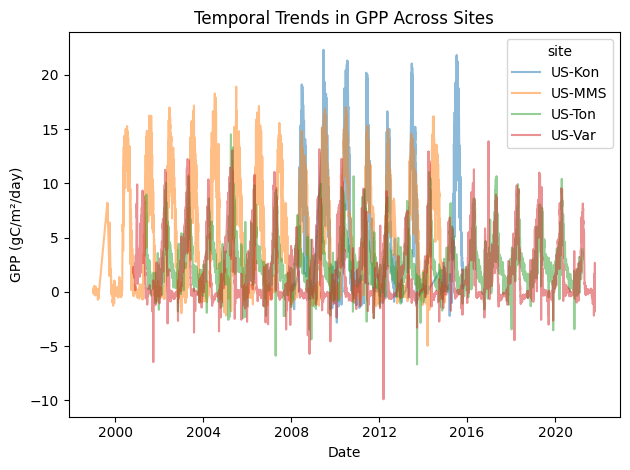

In [17]:
import matplotlib.dates as mdates

# Convert timestamp to datetime for plotting
df_all["DATE"] = pd.to_datetime(df_all["TIMESTAMP"], format="%Y%m%d")

# Line plot of GPP per site
sns.lineplot(data=df_all, x="DATE", y="GPP_NT_VUT_REF", hue="site", alpha=0.5)
plt.title("Temporal Trends in GPP Across Sites")
plt.ylabel("GPP (gC/m²/day)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


Understaning the importance of seasons, Engineer 2 more features - month (numerical) and season (categorial)


In [18]:
# Convert TIMESTAMP to datetime if not already done
df_scaled["DATE"] = pd.to_datetime(df_scaled["TIMESTAMP"].astype(str), format="%Y%m%d")

# Extract month and season
df_scaled["month"] = df_scaled["DATE"].dt.month

# Define season mapping (Northern Hemisphere)
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df_scaled["season"] = df_scaled["month"].apply(get_season)

# One-hot encode season (for linear models)
season_dummies = pd.get_dummies(df_scaled["season"], prefix="season")
df_scaled = pd.concat([df_scaled, season_dummies], axis=1)

# Add to predictors, drop 'Fall' as baseline
for col in season_dummies.columns:
    if col not in predictors:
        predictors.append(col)

# include 'month' as numeric predictor
if "month" not in predictors:
    predictors.append("month")


# Check sample
df_scaled[["DATE", "month", "season"] + list(season_dummies.columns)].head()


DATE  month  season  season_Fall  season_Spring  season_Summer  \
18741 2008-01-07      1  Winter        False          False          False   
18742 2008-01-08      1  Winter        False          False          False   
18743 2008-01-09      1  Winter        False          False          False   
18744 2008-01-10      1  Winter        False          False          False   
18745 2008-01-11      1  Winter        False          False          False   

       season_Winter  
18741           True  
18742           True  
18743           True  
18744           True  
18745           True

Correlation with GPP (season dummies):
GPP_NT_VUT_REF    1.00
season_Winter    -0.27
season_Spring     0.22
season_Summer     0.26
season_Fall      -0.22
Name: GPP_NT_VUT_REF, dtype: float64


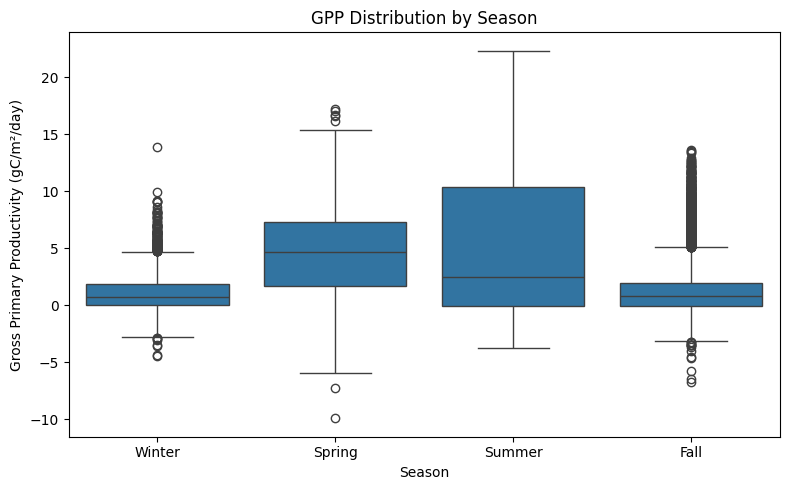

In [20]:
# Correlation of each season dummy with GPP
season_corr = df_scaled[["GPP_NT_VUT_REF", "season_Winter", "season_Spring", "season_Summer", "season_Fall"]].corr()
print("Correlation with GPP (season dummies):")
print(season_corr["GPP_NT_VUT_REF"].round(2))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x="season", y="GPP_NT_VUT_REF", data=df_scaled)
plt.title("GPP Distribution by Season")
plt.ylabel("Gross Primary Productivity (gC/m²/day)")
plt.xlabel("Season")
plt.tight_layout()
plt.show()


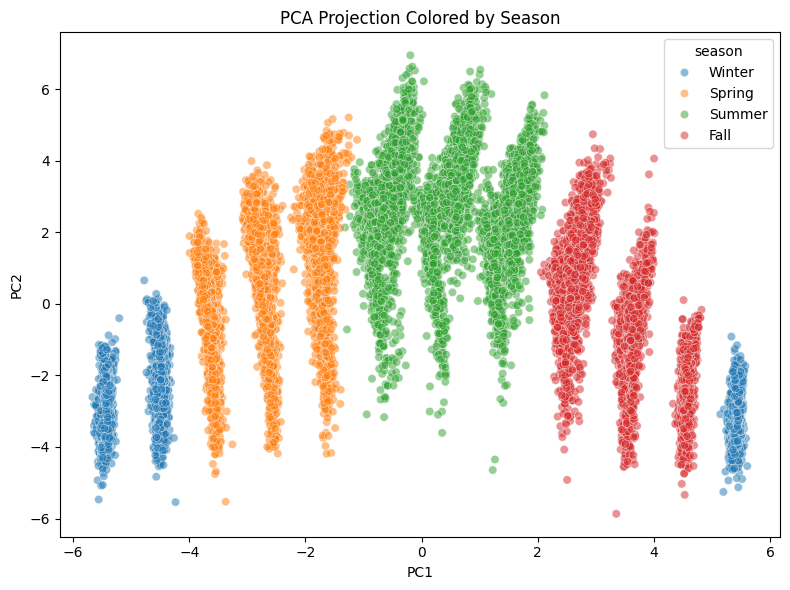

Top 10 loadings for PC1:
month                0.983884
season_Fall          0.075557
TA_F                 0.061768
season_Spring       -0.058618
LE_F_MDS            -0.056470
VPD_F                0.055869
TEMP_X_VPD           0.054648
RADIATION_BALANCE   -0.045811
NETRAD              -0.045302
GPP_LAG1            -0.044697
Name: PC1, dtype: float64

Top 10 loadings for PC2:
PPFD_IN              0.376109
RADIATION_BALANCE    0.357780
NETRAD               0.349454
TA_F                 0.336697
VPD_F                0.330636
G_F_MDS              0.325017
TEMP_X_VPD           0.319314
H_F_MDS              0.298334
LE_F_MDS             0.144524
WS_F                -0.130640
Name: PC2, dtype: float64


In [22]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Run PCA on standardized predictors (excluding GPP and season dummies)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled[predictors])

# Add to DataFrame for plotting
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["season"] = df_scaled["season"].values

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="season", alpha=0.5)
plt.title("PCA Projection Colored by Season")
plt.tight_layout()
plt.show()

# Create a DataFrame of PCA loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2"],
    index=df_scaled[predictors].columns
)

# Sort by absolute value to find top contributing features
top_pc1 = loadings["PC1"].abs().sort_values(ascending=False).head(10)
top_pc2 = loadings["PC2"].abs().sort_values(ascending=False).head(10)

# Display top features contributing to PC1 and PC2
print("Top 10 loadings for PC1:")
print(loadings.loc[top_pc1.index, "PC1"])

print("\nTop 10 loadings for PC2:")
print(loadings.loc[top_pc2.index, "PC2"])

Top 10 loadings for PC1:
month                0.983884
season_Fall          0.075557
Air Temperature      0.061768
season_Spring       -0.058618
Latent Heat Flux    -0.056470
Vapor Pressure       0.055869
TEMP_X_VPD           0.054648
RADIATION_BALANCE   -0.045811
Net Radiation       -0.045302
GPP_LAG1            -0.044697
Name: PC1, dtype: float64

Top 10 loadings for PC2:
Photosynthetic Photon Flux Density    0.376109
RADIATION_BALANCE                     0.357780
Net Radiation                         0.349454
Air Temperature                       0.336697
Vapor Pressure                        0.330636
Ground Heat Flux                      0.325017
TEMP_X_VPD                            0.319314
Sensible Heat Flux                    0.298334
Latent Heat Flux                      0.144524
Wind Speed                           -0.130640
Name: PC2, dtype: float64


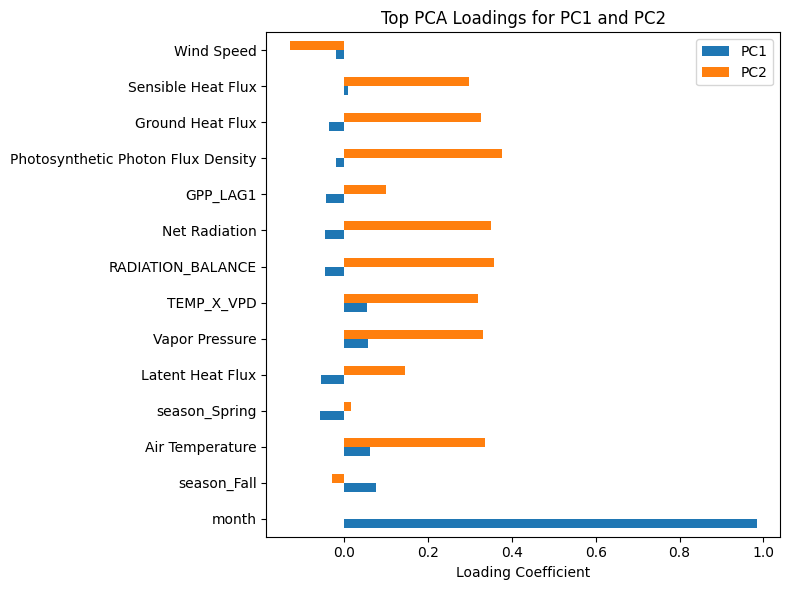

In [23]:
# Define name mapping again (if not already in scope)
feature_names = {
    "GPP_NT_VUT_REF": "Gross Primary Productivity",
    "TA_F": "Air Temperature",
    "VPD_F": "Vapor Pressure",
    "PPFD_IN": "Photosynthetic Photon Flux Density",
    "PA_F": "Air Pressure",
    "P_F": "Precipitation",
    "WS_F": "Wind Speed",
    "LE_F_MDS": "Latent Heat Flux",
    "H_F_MDS": "Sensible Heat Flux",
    "G_F_MDS": "Ground Heat Flux",
    "NETRAD": "Net Radiation"
}

# Create DataFrame of loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2"],
    index=df_scaled[predictors].columns
)

# Top 10 contributing features for each component
top_pc1 = loadings["PC1"].abs().sort_values(ascending=False).head(10)
top_pc2 = loadings["PC2"].abs().sort_values(ascending=False).head(10)

# Rename features using dictionary
loadings_renamed = loadings.rename(index=lambda x: feature_names.get(x, x))

# Display results
print("Top 10 loadings for PC1:")
print(loadings_renamed.loc[top_pc1.index.map(lambda x: feature_names.get(x, x)), "PC1"])

print("\nTop 10 loadings for PC2:")
print(loadings_renamed.loc[top_pc2.index.map(lambda x: feature_names.get(x, x)), "PC2"])

# Combine top features (raw names)
top_features_raw = pd.concat([top_pc1, top_pc2]).index.unique()

# Map to readable names
top_features_named = [feature_names.get(f, f) for f in top_features_raw]

# Subset loadings using readable names
loadings_renamed.loc[top_features_named].plot(kind='barh', figsize=(8, 6))
plt.title("Top PCA Loadings for PC1 and PC2")
plt.xlabel("Loading Coefficient")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


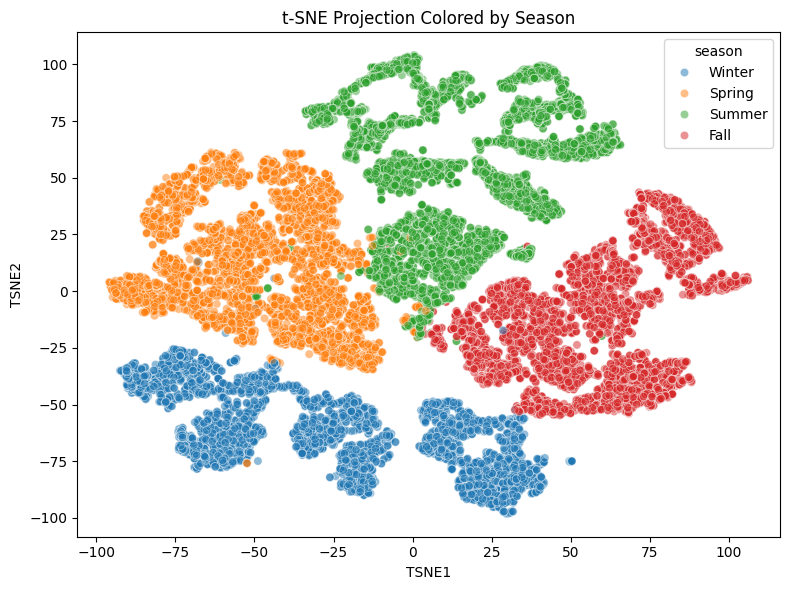

In [ ]:
from sklearn.manifold import TSNE

# Run t-SNE on scaled predictors
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(df_scaled[predictors])

# Add to DataFrame for plotting
tsne_df = pd.DataFrame(tsne_result, columns=["TSNE1", "TSNE2"])
tsne_df["season"] = df_all["season"].values

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="season", alpha=0.5)
plt.title("t-SNE Projection Colored by Season")
plt.tight_layout()
plt.show()


# **Phase 3: Supervised Learning**

## Data set-up for prediction models

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# === Define feature sets ===
gpp_history_features = predictors  # All features, including GPP_LAG1, GPP_DIFF, GPP_VAR7
gpp_independent_features = [f for f in predictors if f not in ["GPP_LAG1", "GPP_DIFF", "GPP_VAR7"]]

# === Define datasets ===
X_gpp = df_scaled[gpp_history_features]
X_no_gpp = df_scaled[gpp_independent_features]
y = df_scaled[target]

# === Train-test split (same random seed for fair comparison) ===
X_gpp_train, X_gpp_test, y_gpp_train, y_gpp_test, = train_test_split(
    X_gpp, y, test_size=0.2, random_state=42
)

X_no_gpp_train, X_no_gpp_test, y_no_gpp_train, y_no_gpp_test, = train_test_split(
    X_no_gpp, y, test_size=0.2, random_state=42
)


## 1. OLS

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
import numpy as np

# Define RMSE manually
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

rmse_scorer = make_scorer(rmse, greater_is_better=False)  # Needs to be negated internally

def evaluate_ols_cv(X, y, label="", cv=5, tol=1e-5):
    model = LinearRegression()

    # Cross-validate RMSE and R²
    rmse_scores = -cross_val_score(model, X, y, cv=cv, scoring=rmse_scorer)
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')

    # Train on full data to get coefficients
    model.fit(X, y)

    # Print cross-validation results
    print(f"\n=== OLS Cross-Validation Results ({label}) ===")
    print(f"Avg RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
    print(f"Avg R²:   {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

    # Print the equation (exclude near-zero coefficients)
    coefs = model.coef_
    intercept = model.intercept_
    feature_names = X.columns
    terms = [
        f"{coef:.4f}·{name}"
        for coef, name in zip(coefs, feature_names)
        if abs(coef) > tol
    ]
    equation = f"GPP_NT_VUT_REF = {intercept:.4f}" + (" + " + " + ".join(terms) if terms else "")
    print("\nOLS Regression Equation:")
    print(equation)

    return model, rmse_scores, r2_scores


### Run OLS with GPP history

In [26]:
OLS_model = evaluate_ols_cv(X_gpp_train, y_gpp_train, label="With GPP History")


=== OLS Cross-Validation Results (With GPP History) ===
Avg RMSE: 0.0000 ± 0.0000
Avg R²:   1.0000 ± 0.0000

OLS Regression Equation:
GPP_NT_VUT_REF = 3.1767 + 4.1459·GPP_LAG1 + 1.3165·GPP_DIFF


### Run OLS without GPP history

In [43]:
OLS_model,_,_ = evaluate_ols_cv(X_no_gpp_train, y_no_gpp_train, label="Without GPP History")


=== OLS Cross-Validation Results (Without GPP History) ===
Avg RMSE: 1.7669 ± 0.0093
Avg R²:   0.8172 ± 0.0073

OLS Regression Equation:
GPP_NT_VUT_REF = 3.3757 + 1.2483·TA_F + -3.0815·VPD_F + 0.1767·PA_F + -0.2355·P_F + 0.0535·WS_F + 2.6809·LE_F_MDS + -0.9474·H_F_MDS + -0.2264·G_F_MDS + 0.9301·PPFD_IN + -0.0507·NETRAD + 1.6382·TEMP_X_VPD + -0.0677·RADIATION_BALANCE + -0.2773·season_Fall + -0.1123·season_Spring + 0.9109·season_Summer + -0.5213·season_Winter + -0.0344·month


## 2. Ridge Regression

In [28]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer

# Define RMSE scorer (again, in case not already defined)
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

def evaluate_ridge_cv(X, y, label="", cv=5, alphas=[0.01, 0.1, 1.0, 10.0, 100.0]):
    ridge = Ridge()
    grid = GridSearchCV(ridge, param_grid={'alpha': alphas}, cv=cv, scoring=rmse_scorer)
    grid.fit(X, y)

    best_ridge = grid.best_estimator_

    # Cross-validate with best alpha
    rmse_scores = -cross_val_score(best_ridge, X, y, cv=cv, scoring=rmse_scorer)
    r2_scores = cross_val_score(best_ridge, X, y, cv=cv, scoring='r2')

    print(f"\n=== Ridge Regression Results ({label}) ===")
    print(f"Best alpha: {grid.best_params_['alpha']}")
    print(f"Avg RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
    print(f"Avg R²:   {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

    # Print regression equation (non-zero coefficients only)
    coefs = best_ridge.coef_
    intercept = best_ridge.intercept_
    terms = [f"{coef:.4f}·{name}" for coef, name in zip(coefs, X.columns) if abs(coef) > 1e-4]
    equation = f"GPP_NT_VUT_REF = {intercept:.4f} + " + " + ".join(terms)
    print("\nRidge Regression Equation:")
    print(equation)

    return best_ridge


In [29]:
ridge_model = evaluate_ridge_cv(X_no_gpp, y, label="Without GPP History")


=== Ridge Regression Results (Without GPP History) ===
Best alpha: 0.01
Avg RMSE: 2.2646 ± 0.6649
Avg R²:   0.4777 ± 0.4334

Ridge Regression Equation:
GPP_NT_VUT_REF = 3.3715 + 1.2428·TA_F + -3.0821·VPD_F + 0.1698·PA_F + -0.2287·P_F + 0.0612·WS_F + 2.6689·LE_F_MDS + -0.9497·H_F_MDS + -0.2277·G_F_MDS + 0.9510·PPFD_IN + -0.0574·NETRAD + 1.6377·TEMP_X_VPD + -0.0741·RADIATION_BALANCE + -0.2742·season_Fall + -0.1068·season_Spring + 0.9284·season_Summer + -0.5474·season_Winter + -0.0344·month


## 3. Lasso Regression

In [30]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np

def evaluate_lasso(X, y, alphas=np.logspace(-4, 1, 50), cv=5):
    lasso = LassoCV(alphas=alphas, cv=cv, random_state=42, max_iter=10000)
    lasso.fit(X, y)

    # Best alpha
    best_alpha = lasso.alpha_

    # Cross-validated RMSE and R²
    y_pred = lasso.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)

    # Print results
    print("\n=== Lasso Regression Results (Without GPP History) ===")
    print(f"Best alpha: {best_alpha}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    # Print regression formula with non-zero coefficients
    coef = lasso.coef_
    intercept = lasso.intercept_

    terms = [
        f"{coef[i]:+.4f}·{X.columns[i]}"
        for i in range(len(coef)) if abs(coef[i]) > 1e-4
    ]
    equation = f"GPP_NT_VUT_REF = {intercept:.4f} " + " ".join(terms)
    print("\nLasso Regression Equation:")
    print(equation)

    return lasso


In [31]:
lasso_model = evaluate_lasso(X_no_gpp_train, y_no_gpp_train)



=== Lasso Regression Results (Without GPP History) ===
Best alpha: 0.0001
RMSE: 1.7645
R²:   0.8180

Lasso Regression Equation:
GPP_NT_VUT_REF = 3.2621 +1.2474·TA_F -3.0722·VPD_F +0.1765·PA_F -0.2350·P_F +0.0530·WS_F +2.6824·LE_F_MDS -0.9459·H_F_MDS -0.2207·G_F_MDS +0.9265·PPFD_IN -0.0014·NETRAD +1.6299·TEMP_X_VPD -0.1189·RADIATION_BALANCE -0.1631·season_Fall +1.0243·season_Summer -0.4067·season_Winter -0.0344·month


## 4. Random forest

In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression

# Define function to evaluate Random Forest model with cross-validation
def evaluate_random_forest_cv(X, y, label="", cv=5, random_state=42):
    model = RandomForestRegressor(n_estimators=100, random_state=random_state)

    # Cross-validate RMSE and R²
    rmse_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')

    print(f"\n=== Random Forest Results ({label}) ===")
    print(f"Avg RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
    print(f"Avg R²:   {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

    return model.fit(X, y), rmse_scores, r2_scores


In [33]:
rf_model = evaluate_random_forest_cv(X_no_gpp_train, y_no_gpp_train, label="Without GPP History")


=== Random Forest Results (Without GPP History) ===
Avg RMSE: 1.3110 ± 0.0334
Avg R²:   0.8993 ± 0.0061


## 5. XGBoost

In [34]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import numpy as np

# Custom RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

def evaluate_xgboost_cv(X, y, label="", cv=5):
    model = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    # Cross-validation scores
    rmse_scores = -cross_val_score(model, X, y, cv=cv, scoring=rmse_scorer)
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')

    # Train model on full data (optional, for inspection)
    model.fit(X, y)

    # Print results
    print(f"\n=== XGBoost Results ({label}) ===")
    print(f"Avg RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    print(f"Avg R²:   {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    return model


In [35]:
xgb_model = evaluate_xgboost_cv(X_no_gpp_train, y_no_gpp_train, label="Without GPP History")



=== XGBoost Results (Without GPP History) ===
Avg RMSE: 1.3116 ± 0.0279
Avg R²:   0.8993 ± 0.0050


Top 15 Feature Importances (Natural Language):

Latent Heat Flux: 0.3853
season_Summer: 0.2427
RADIATION_BALANCE: 0.0663
season_Spring: 0.0527
Sensible Heat Flux: 0.0484
Air Pressure: 0.0382
Vapor Pressure: 0.0300
Net Radiation: 0.0273
Wind Speed: 0.0213
Air Temperature: 0.0204
month: 0.0187
Photosynthetic Photon Flux Density: 0.0140
TEMP_X_VPD: 0.0104
season_Winter: 0.0075
Ground Heat Flux: 0.0062


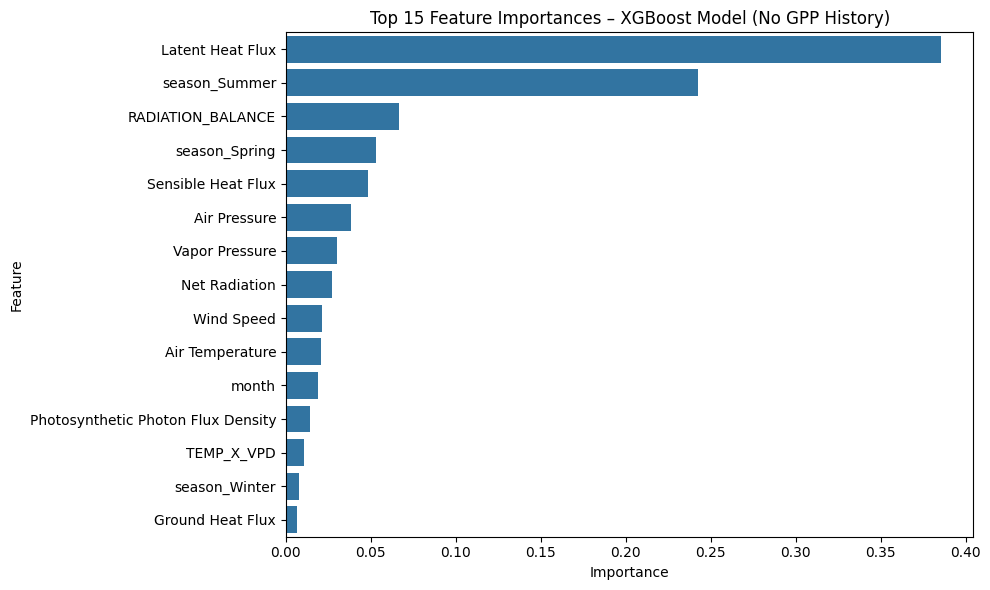

In [36]:
# Get feature importances from the XGBoost model
importances = xgb_model.feature_importances_
feature_names_list = X_no_gpp_train.columns

# Create DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names_list,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Translate feature names to natural language
importance_df["Feature"] = importance_df["Feature"].apply(lambda x: feature_names.get(x, x))

# Print top 15
top_15 = importance_df.head(15)
print("Top 15 Feature Importances (Natural Language):\n")
for i, row in top_15.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

# Plot without grid
plt.figure(figsize=(10, 6))
sns.barplot(data=top_15, x="Importance", y="Feature")
plt.title("Top 15 Feature Importances – XGBoost Model (No GPP History)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(False)  # Disable grid
plt.tight_layout()
plt.show()

## 6. Support Vector Regression (SVR)

In [94]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np

# Define RMSE manually (again, just in case)
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

def evaluate_svr_cv(X, y, cv=5):
    # Define parameter grid
    param_grid = {
        "C": [0.1, 1, 10],
        "epsilon": [0.1, 0.5, 1],
        "kernel": ["rbf"]
    }

    svr = SVR()
    grid_search = GridSearchCV(svr, param_grid, cv=cv, scoring=rmse_scorer, n_jobs=-1)
    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_

    # Cross-validate RMSE and R² using the best model
    rmse_scores = -cross_val_score(best_model, X, y, cv=cv, scoring=rmse_scorer)
    r2_scores = cross_val_score(best_model, X, y, cv=cv, scoring='r2')

    print(f"\n=== SVR Results ===")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Avg RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
    print(f"Avg R²:   {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

    return best_model, rmse_scores, r2_scores


In [95]:
svr_model, svr_rmse, svr_r2 = evaluate_svr_cv(X_no_gpp, y)



=== SVR Results ===
Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Avg RMSE: 1.7199 ± 0.3678
Avg R²:   0.7282 ± 0.1476


## Test Set Evaluation

In [38]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_on_test_set(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # compute RMSE manually
    r2 = r2_score(y_test, y_pred)

    print("=== Test Set Evaluation ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    return y_pred  # for residual diagnostics



In [50]:
print("")
print("\nOLS Regression Evaluation\n")
evaluate_on_test_set(OLS_model,X_no_gpp_test,y_no_gpp_test)
print("")
print("|")
print("|")
print("\nRidge Regression Evaluation\n")
evaluate_on_test_set(ridge_model,X_no_gpp_test,y_no_gpp_test)
print("")
print("|")
print("|")
print("\nLasso Regression Evaluation\n")
evaluate_on_test_set(lasso_model,X_no_gpp_test,y_no_gpp_test)
print("")
print("|")
print("|")
print("\nRandom Forest Evaluation\n")
trained_rf_model = rf_model[0]
evaluate_on_test_set(trained_rf_model,X_no_gpp_test,y_no_gpp_test)
print("")
print("|")
print("|")
print("\nXGBoost Evaluation\n")
evaluate_on_test_set(xgb_model,X_no_gpp_test,y_no_gpp_test)






OLS Regression Evaluation

=== Test Set Evaluation ===
RMSE: 1.7778
R²:   0.8196

|
|

Ridge Regression Evaluation

=== Test Set Evaluation ===
RMSE: 1.7767
R²:   0.8198

|
|

Lasso Regression Evaluation

=== Test Set Evaluation ===
RMSE: 1.7778
R²:   0.8196

|
|

Random Forest Evaluation

=== Test Set Evaluation ===
RMSE: 1.2597
R²:   0.9094

|
|

XGBoost Evaluation

=== Test Set Evaluation ===
RMSE: 1.2628
R²:   0.9090


array([0.8530187 , 0.69604844, 6.212618  , ..., 1.9314739 , 0.3179668 ,
       1.788756  ], dtype=float32)

## Residualest Diagnostics

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred

    plt.figure(figsize=(12, 5))

    # Residuals histogram
    plt.subplot(1, 2, 1)
    sns.histplot(residuals, kde=True, bins=30)
    plt.title("Residual Distribution")
    plt.xlabel("Residuals")

    # Residuals vs Fitted using sns.residplot for automatic smoothing
    plt.subplot(1, 2, 2)
    sns.residplot(x=y_pred, y=residuals, lowess=True, scatter_kws={'alpha': 0.4}, line_kws={"color": "red", "linestyle": "--"})
    plt.title("Residuals vs. Predicted")
    plt.xlabel("Predicted GPP")
    plt.ylabel("Residuals")

    plt.tight_layout()
    plt.show()





OLS Regression Evaluation

=== Test Set Evaluation ===
RMSE: 1.7778
R²:   0.8196


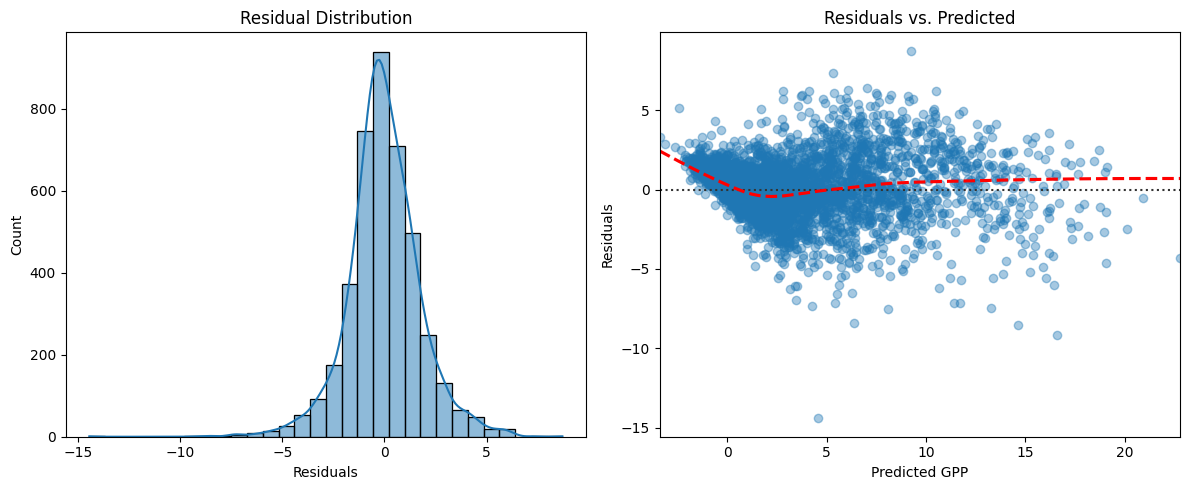


|
|

Ridge Regression Evaluation

=== Test Set Evaluation ===
RMSE: 1.7767
R²:   0.8198


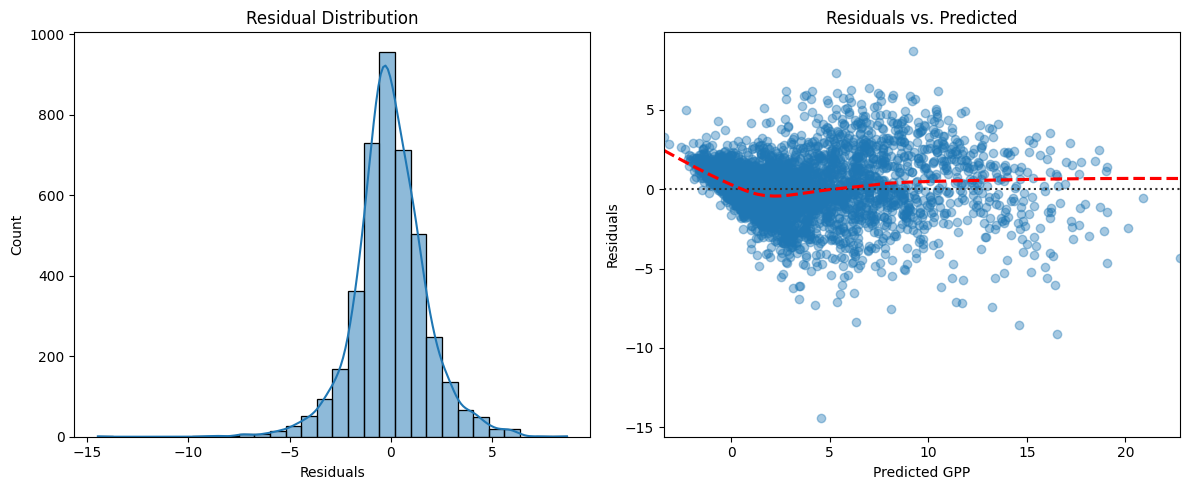


|
|

Lasso Regression Evaluation

=== Test Set Evaluation ===
RMSE: 1.7778
R²:   0.8196


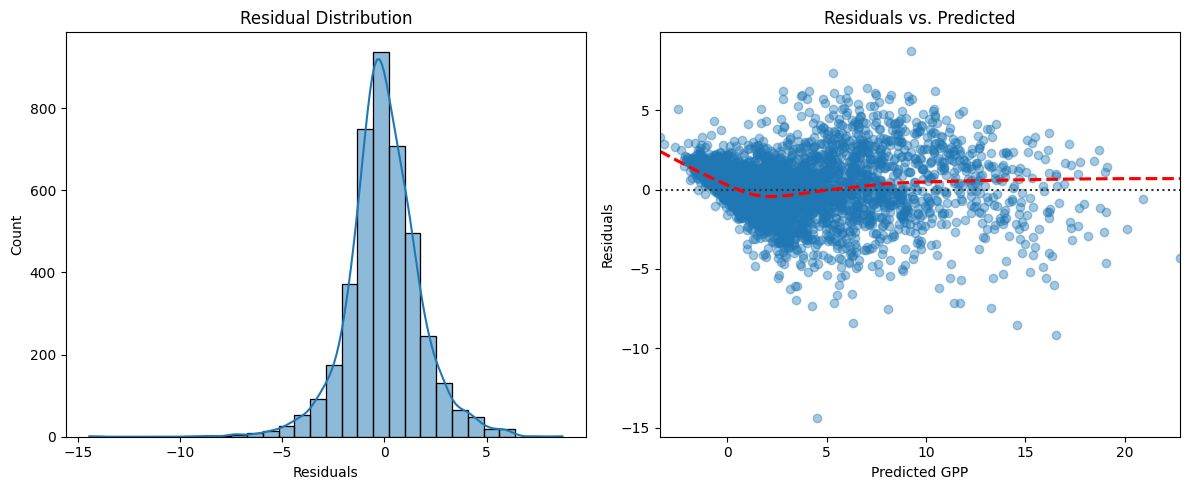


|
|

Random Forest Evaluation

=== Test Set Evaluation ===
RMSE: 1.2597
R²:   0.9094


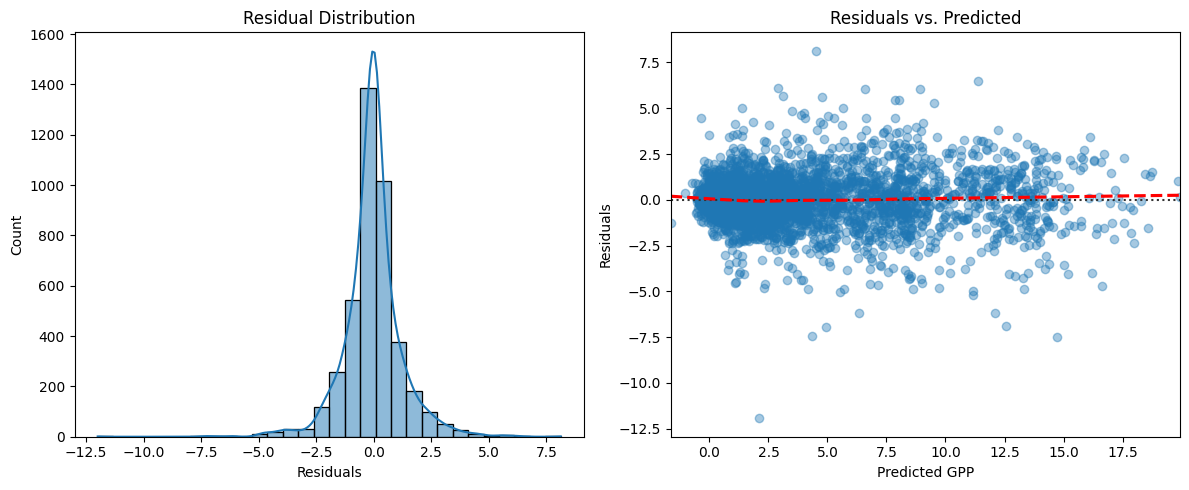


|
|

XGBoost Evaluation

=== Test Set Evaluation ===
RMSE: 1.2628
R²:   0.9090


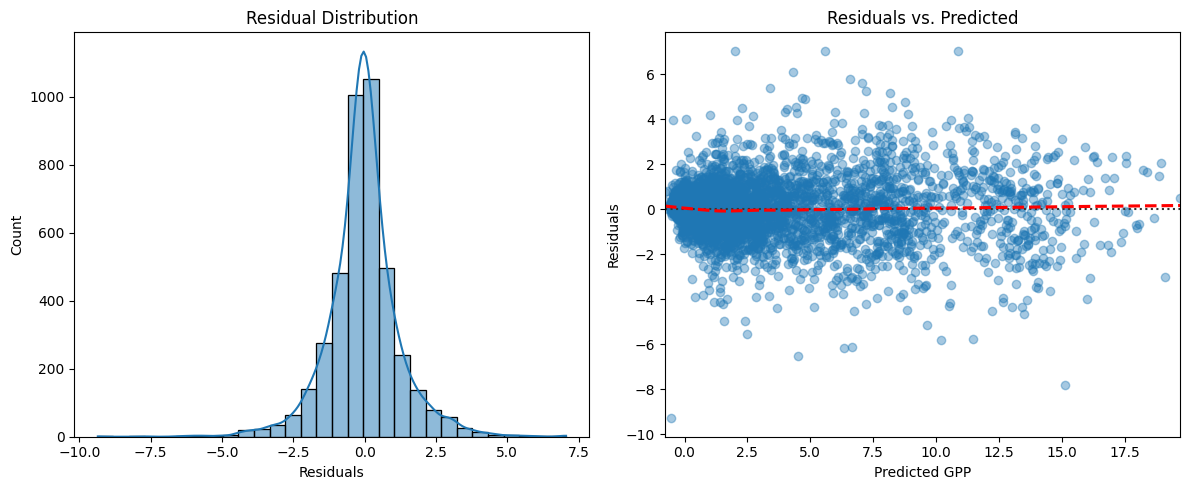

In [51]:
# OLS Residuals
print("")
print("\nOLS Regression Evaluation\n")
y_pred_ols = evaluate_on_test_set(OLS_model, X_no_gpp_test, y_no_gpp_test)
plot_residuals(y_no_gpp_test, y_pred_ols)

# Ridge Residuals
print("")
print("|")
print("|")
print("\nRidge Regression Evaluation\n")
y_pred_ridge = evaluate_on_test_set(ridge_model, X_no_gpp_test, y_no_gpp_test)
plot_residuals(y_no_gpp_test, y_pred_ridge)

# Lasso Residuals
print("")
print("|")
print("|")
print("\nLasso Regression Evaluation\n")
y_pred_lasso = evaluate_on_test_set(lasso_model, X_no_gpp_test, y_no_gpp_test)
plot_residuals(y_no_gpp_test, y_pred_lasso)

# Random Forest Residuals
print("")
print("|")
print("|")
print("\nRandom Forest Evaluation\n")
y_pred_rf = evaluate_on_test_set(rf_model[0], X_no_gpp_test, y_no_gpp_test)
plot_residuals(y_no_gpp_test, y_pred_rf)

# XGBoost Residuals
print("")
print("|")
print("|")
print("\nXGBoost Evaluation\n")
y_pred_xgb = evaluate_on_test_set(xgb_model, X_no_gpp_test, y_no_gpp_test)
plot_residuals(y_no_gpp_test, y_pred_xgb)


# **Phase 4: Unsupervised Learning**

## Prepare data for clustering

In [11]:
from sklearn.preprocessing import StandardScaler

# Select features for unsupervised learning (no GPP target or lagged features)
unsupervised_features = [
    f for f in predictors
    if f not in ["GPP_NT_VUT_REF", "GPP_LAG1", "GPP_DIFF", "GPP_VAR7"]
]

X_unsupervised = df_scaled[unsupervised_features]


## K-means

In [12]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

def run_kmeans_clustering(X, k=3):
    # Run KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)

    # Compute silhouette score
    sil_score = silhouette_score(X, cluster_labels)

    # PCA for visualization
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

    # Plot clusters in PCA space
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=cluster_labels, palette='Set2', alpha=0.6)
    plt.title(f"K-Means Clustering (k={k}) in PCA Space\nSilhouette Score = {sil_score:.3f}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

    return cluster_labels, sil_score


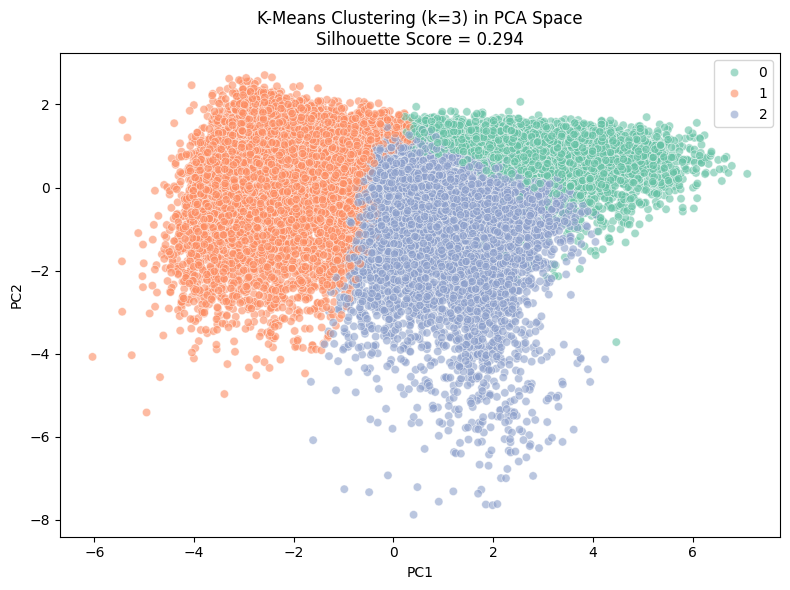

Silhouette Score for K-Means Clustering(k=3): 0.294


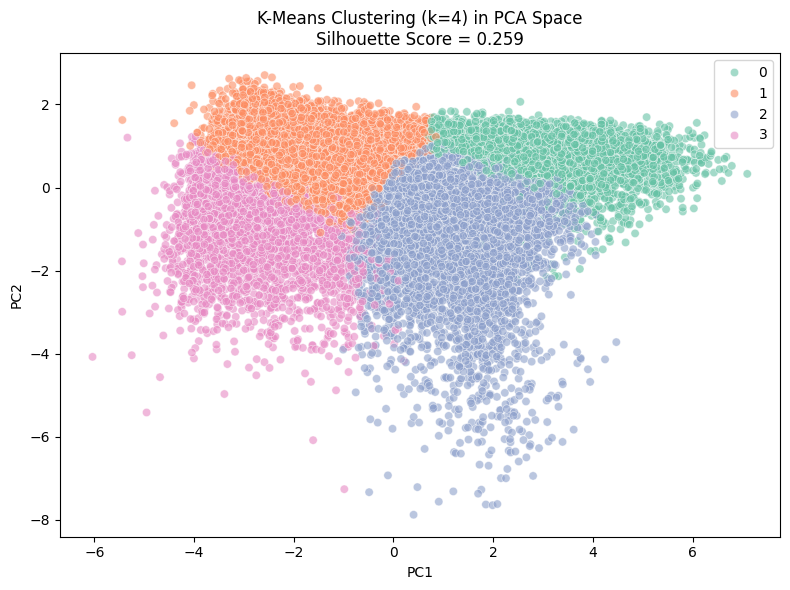

Silhouette Score for K-Means Clustering(k=4): 0.259


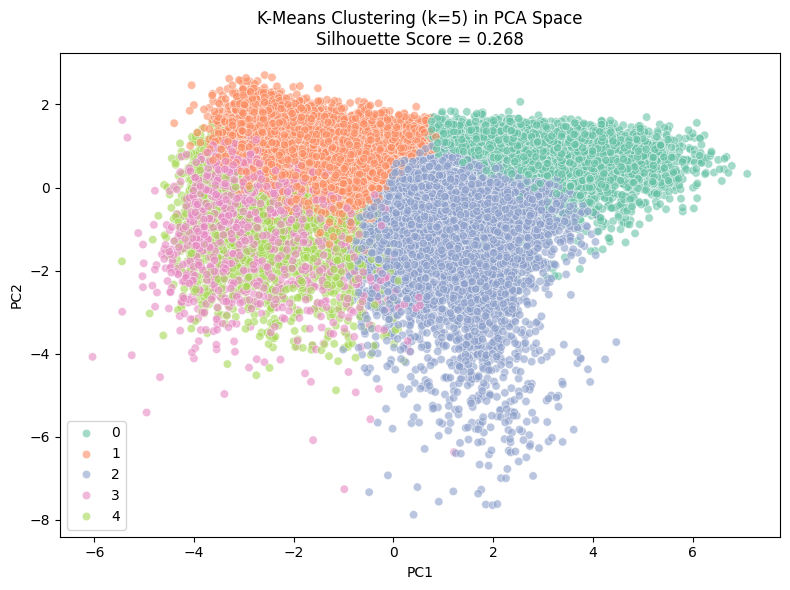

Silhouette Score for K-Means Clustering(k=5): 0.268


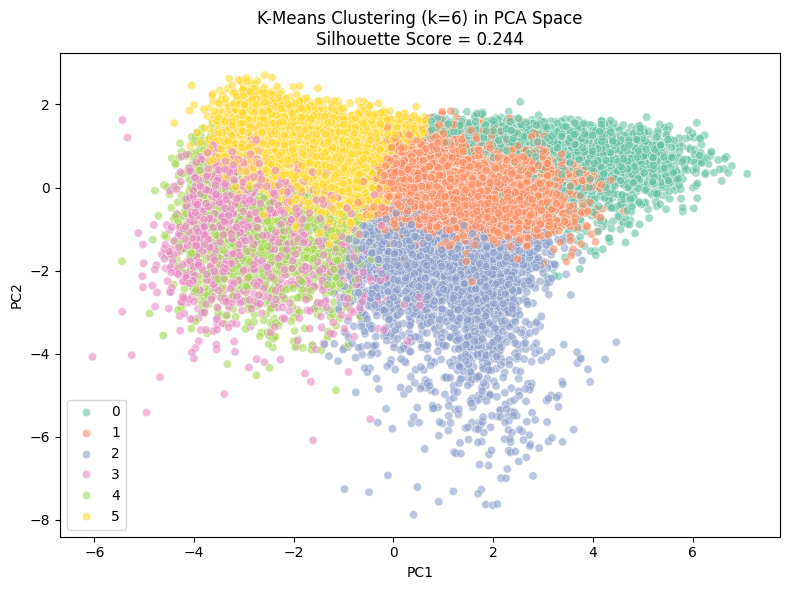

Silhouette Score for K-Means Clustering(k=6): 0.244


In [13]:
for i in range(3, 7):
    kmeans_labels, kmeans_sil = run_kmeans_clustering(X_unsupervised, k=i)
    print(f"Silhouette Score for K-Means Clustering(k={i}): {kmeans_sil:.3f}")


## Agglomerative Clustering

In [14]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def run_agglomerative_clustering(X, n_clusters=3):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = model.fit_predict(X)

    # Compute Silhouette Score
    sil_score = silhouette_score(X, labels)

    # PCA for visualization
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=labels, palette='Set2', alpha=0.6)
    plt.title(f"Agglomerative Clustering (k={n_clusters}) in PCA Space\nSilhouette Score = {sil_score:.3f}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

    return labels, sil_score


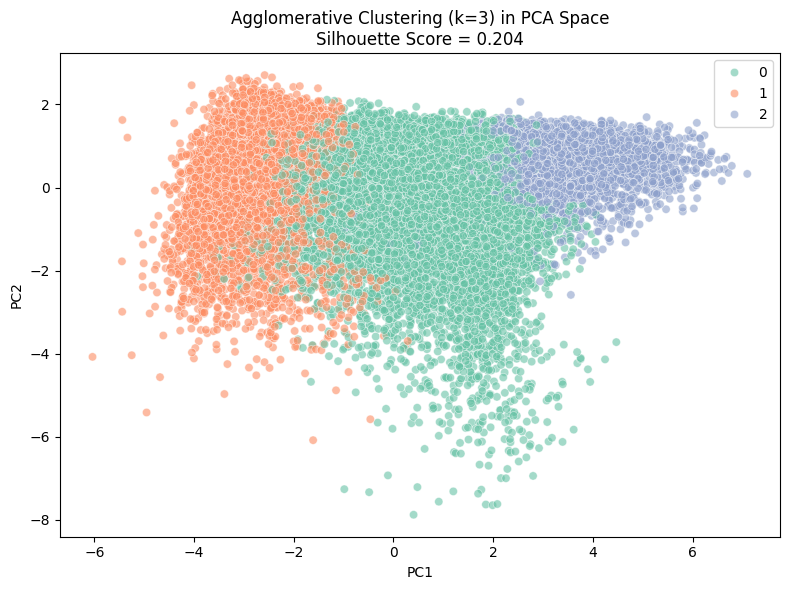

Silhouette Score for Agglomerative Clustering (k=3): 0.204


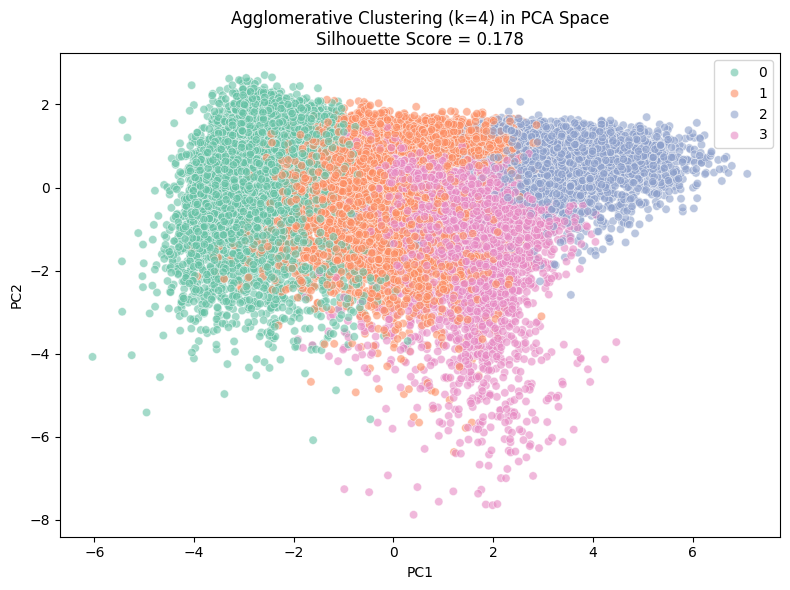

Silhouette Score for Agglomerative Clustering (k=4): 0.178


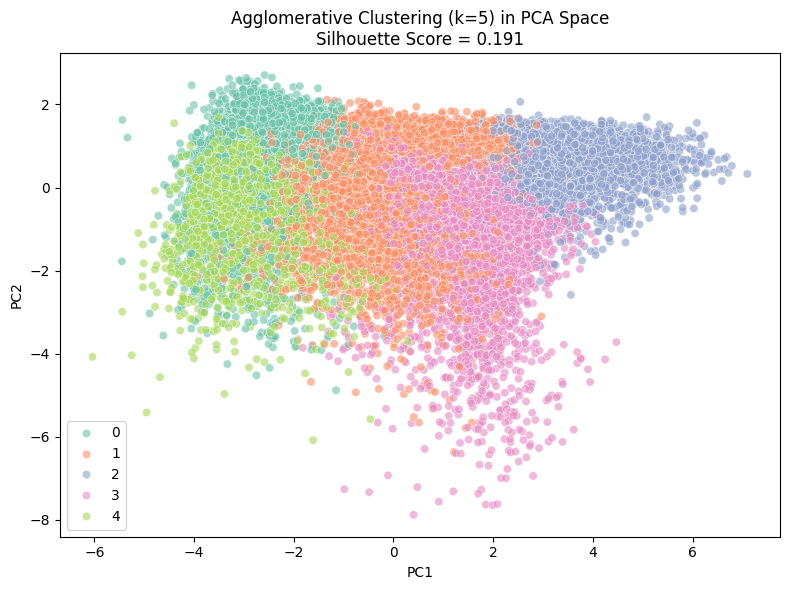

Silhouette Score for Agglomerative Clustering (k=5): 0.191


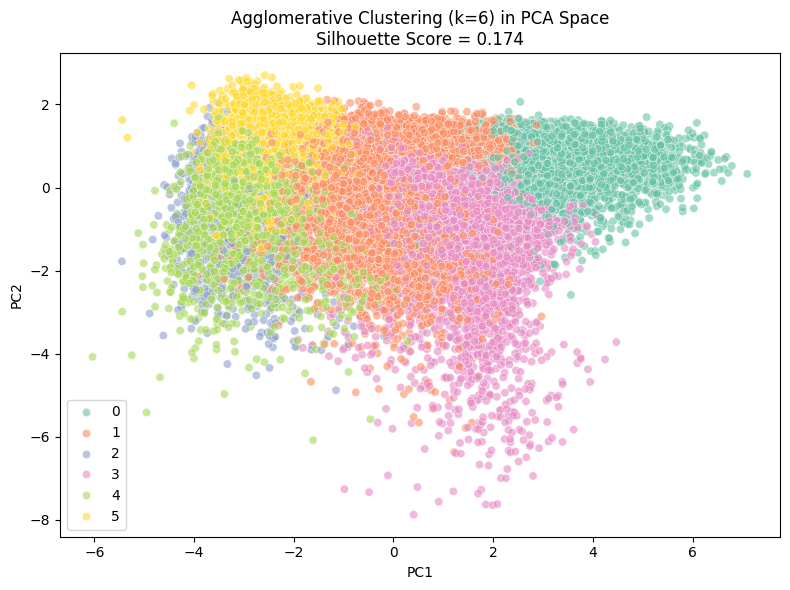

Silhouette Score for Agglomerative Clustering (k=6): 0.174


In [15]:
for k in range(3, 7):
    _, score = run_agglomerative_clustering(X_unsupervised , n_clusters=k)
    print(f"Silhouette Score for Agglomerative Clustering (k={k}): {score:.3f}")


## DBSCAN

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

def run_dbscan_and_evaluate(X, eps_values, min_samples_values):
    for eps in eps_values:
        for min_samples in min_samples_values:
            db = DBSCAN(eps=eps, min_samples=min_samples)
            labels = db.fit_predict(X)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)

            # Only compute silhouette score if more than 1 cluster
            if n_clusters > 1:
                score = silhouette_score(X[labels != -1], labels[labels != -1])
                print(f"DBSCAN (eps={eps}, min_samples={min_samples}): "
                      f"{n_clusters} clusters, {n_noise} noise points, Silhouette Score: {score:.3f}")
            else:
                print(f"DBSCAN (eps={eps}, min_samples={min_samples}): "
                      f"{n_clusters} clusters, {n_noise} noise points, Silhouette Score: N/A (insufficient clusters)")


In [17]:
eps_values = [0.5, 1.0, 1.5]
min_samples_values = [5, 10, 15, 20]

run_dbscan_and_evaluate(X_unsupervised.values, eps_values, min_samples_values)


DBSCAN (eps=0.5, min_samples=5): 109 clusters, 13269 noise points, Silhouette Score: -0.540
DBSCAN (eps=0.5, min_samples=10): 37 clusters, 15962 noise points, Silhouette Score: -0.103
DBSCAN (eps=0.5, min_samples=15): 26 clusters, 17493 noise points, Silhouette Score: 0.090
DBSCAN (eps=0.5, min_samples=20): 10 clusters, 18747 noise points, Silhouette Score: 0.381
DBSCAN (eps=1.0, min_samples=5): 21 clusters, 1577 noise points, Silhouette Score: -0.243
DBSCAN (eps=1.0, min_samples=10): 4 clusters, 2314 noise points, Silhouette Score: 0.087
DBSCAN (eps=1.0, min_samples=15): 2 clusters, 2868 noise points, Silhouette Score: 0.212
DBSCAN (eps=1.0, min_samples=20): 1 clusters, 3280 noise points, Silhouette Score: N/A (insufficient clusters)
DBSCAN (eps=1.5, min_samples=5): 3 clusters, 214 noise points, Silhouette Score: 0.339
DBSCAN (eps=1.5, min_samples=10): 1 clusters, 319 noise points, Silhouette Score: N/A (insufficient clusters)
DBSCAN (eps=1.5, min_samples=15): 1 clusters, 410 noise po

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dbscan_clusters(X, labels, title="DBSCAN Clustering in PCA Space"):
    # Reduce to 2D for visualization
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(components, columns=["PC1", "PC2"])
    plot_df["Cluster"] = labels.astype(str)
    plot_df.loc[plot_df["Cluster"] == "-1", "Cluster"] = "Noise"  # Label noise points clearly

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="Cluster", palette="tab20", alpha=0.6)
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


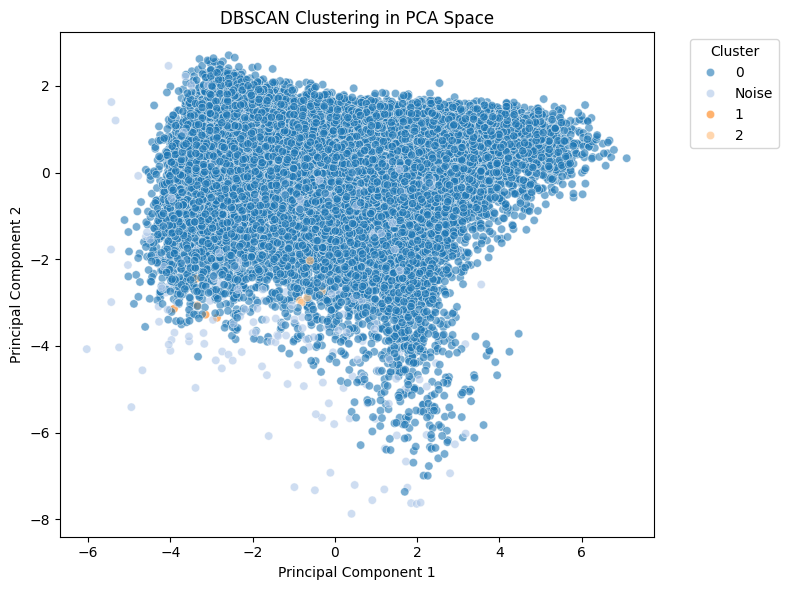

In [21]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan.fit(X_unsupervised)

dbscan_labels = dbscan.labels_

plot_dbscan_clusters(X_unsupervised, dbscan_labels)



## Bonus - sites seperation

### PCA

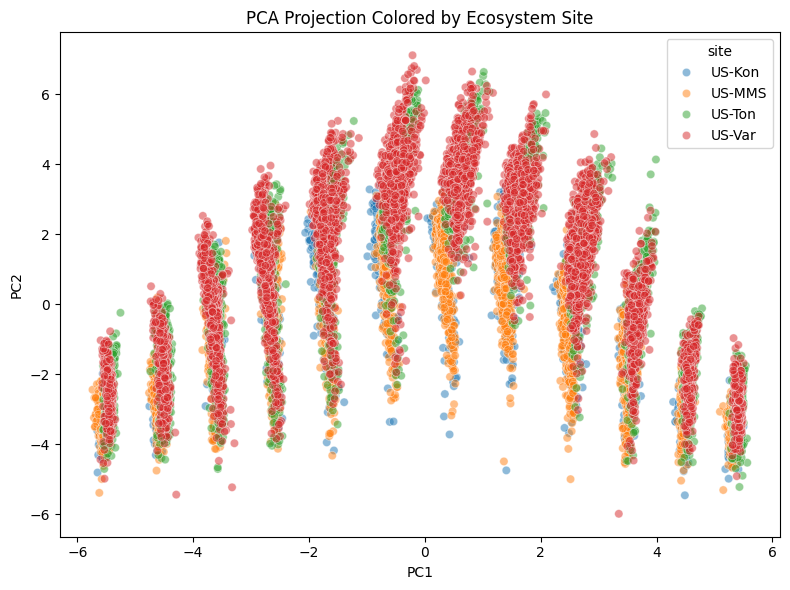

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Run PCA on scaled features
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_unsupervised)

# Create DataFrame with PCA results and site labels
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["site"] = df_all["site"].values  # assuming site is in the original DataFrame

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="site", alpha=0.5)
plt.title("PCA Projection Colored by Ecosystem Site")
plt.tight_layout()
plt.show()


### PCA without temporal predictors

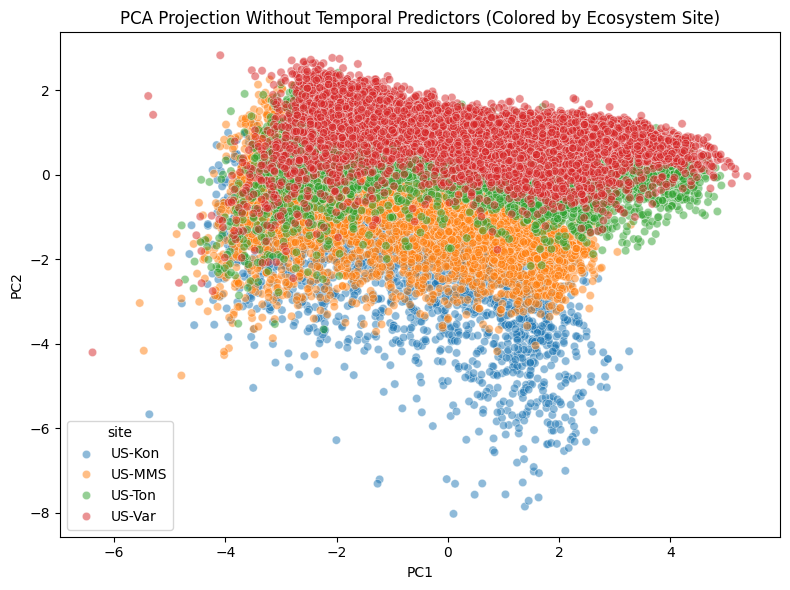

In [64]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Define a reduced feature set without temporal predictors
temporal_features = ['GPP_LAG1', 'GPP_DIFF', 'GPP_VAR7', 'TEMP_X_VPD',
                     'RADIATION_BALANCE', 'month'] + [col for col in df_scaled.columns if col.startswith('season_')]

# Keep only features that are not in the temporal list
non_temporal_features = [col for col in X_unsupervised.columns if col not in temporal_features]

# Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_unsupervised[non_temporal_features])

# Create DataFrame with PCA results and site labels
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["site"] = df_all["site"].values

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="site", alpha=0.5)
plt.title("PCA Projection Without Temporal Predictors (Colored by Ecosystem Site)")
plt.tight_layout()
plt.show()